In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors, __version__ as mplver
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy import __version__ as apver
from scipy import stats, __version__ as spver
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
print(np.__version__,pd.__version__,mplver,apver,spver)

1.17.2 0.25.1 3.1.1 3.2.2 1.3.1


# Let's put together our sample

In [3]:
massive_observed = pd.read_csv('../data/massive_observed.csv')

#here's the YSGs
ysgs = massive_observed[massive_observed['SpT']=='YSG'].reset_index(drop=True)

#here's the RSGs
rsgs = massive_observed[massive_observed['SpT']=='RSG'].reset_index(drop=True)

#Let's get the TIC x-match for a catalog of these stars
ysg_tics = glob('../../Proposals/TESS_C3/data/*YSG_TIC*')
dfs = []
for y in ysg_tics:
    df = pd.read_csv(y,skiprows=4)
    df['SpecSource'] = ['N' for i in range(len(df))]
    dfs.append(df)
ysg_tic = pd.concat(dfs).reset_index(drop=True)[['MatchID','teff','lum','SpecSource','w1mag','w2mag','w3mag','w4mag']]
ysg_tic = ysg_tic[ysg_tic['lum'] > 4.0].reset_index(drop=True)

rsg_tics = glob('../../Proposals/TESS_C3/data/*RSG_TIC*')
rsg_tics.append('../../Proposals/TESS_C3/data/galactic_all_TIC.csv')
dfs = []
for r in rsg_tics:
    if 'MC' in r: #First we use Teff and L from Kathryn's paper
        df = pd.read_csv(r,skiprows=4)
        df['teff'] = np.log10(df['Teff'])
        df['lum'] = df['LogL']
        df['SpecSource'] = ['N' for i in range(len(df))]
        dfs.append(df)
    elif 'Levesque' in r: #Then we get it from Emily's paper
        df = pd.read_csv(r,skiprows=4)
        df['SpecSource'] = ['L' for i in range(len(df))]
        dfs.append(df)
    else: #Then we estimate it from Gaia
        df = pd.read_csv(r,skiprows=4)
        keep = [('K' in S) or ('M' in S) for S in df['SpecType'].values]
        df = df[keep].reset_index(drop=True)
        df['teff'] = np.log10(df['Teff']) #rough T and L from R in TIC. It's not great.
        df['lum'] = 2.0*np.log10(df['rad']) + 4.0*np.log10(df['Teff']/5777.0) #assuming T_sun = 5777
        df['SpecSource'] = ['T' for i in range(len(df))]
        dfs.append(df)
rsg_tic = pd.concat(dfs).reset_index(drop=True)[['MatchID','teff','lum','SpecSource','RA','Dec','w1mag','w2mag','w3mag','w4mag']]
rsg_tic = rsg_tic[rsg_tic['lum'] > 4.0].reset_index(drop=True)
#Now cross match and concatenate
ysg_spec = pd.merge(ysgs,ysg_tic,left_on='TIC ID',right_on='MatchID').sort_values('teff').reset_index(drop=True)
print(len(ysg_spec))
rsg_spec = pd.merge(rsgs,rsg_tic,suffixes=('','_y'),left_on='TIC ID',right_on='MatchID').sort_values('teff').reset_index(drop=True)
rsg_spec.loc[rsg_spec['CommonName']=='V* V772 Cen',['teff','lum','SpecSource']] = [3.56,4.63,'I']
#drop duplicate RSGs
rsg_spec = rsg_spec.sort_values('SpecSource').drop_duplicates(subset='MatchID')
#Estimated from Spectrum published in Ivanov et al. 2019
print(len(rsg_spec))

cool_sgs = pd.concat([ysg_spec,rsg_spec]).sort_values('teff').reset_index(drop=True)

#One star, BD+35 4077 was observed by Levesque et al. so we're going to fix that...
cool_sgs.set_value(3,'teff',np.log10(3600))
cool_sgs.set_value(3,'lum',4.768)
cool_sgs.set_value(3,'SpecSource','L')

cool_sgs

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()
/Users/carina/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,21,23,62,99,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



28
48


/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


CommonName  ContRatio        Dec      Dec_y MKType    MatchID  \
0   V* V1092 Cen        NaN -61.319446 -61.319444     Ma  290678703   
1      V* HS Cas        NaN  63.586529  63.586444   M4Ia   52782147   
2      HD 143183        NaN -54.143224 -54.143194   M2II  423407817   
3    BD+35  4077        NaN  35.621266  35.621278     M2  136034302   
4      V* AD Per        NaN  56.993123  56.993139     K5  348314378   
..           ...        ...        ...        ...    ...        ...   
71     HD 269786        NaN -69.750564        NaN      B  277022505   
72     HD 269101        NaN -68.769410        NaN  B3Iab   40343782   
73   SK -69   68        NaN -69.117163        NaN   B1II   40515514   
74     HD 268798        NaN -68.420082        NaN     B:   30317301   
75     HD 269769        NaN -69.781048        NaN  B0.5I  276936458   

            RA        RA_y     SimbadOType   SimbadSpT  ...     Tmag  \
0   174.109242  174.109250          RedSG*  M2.5Iab-Ib  ...   5.2902   
1    17.083001   17.083042          RedSG*        M4Ia  ...   5.8870   
2   240.400927  240.400958            Star    M1/2+B/F  ...   4.2452   
3   305.308620  305.308625  Candidate_RSG*      M3Iab:  ...   5.6839   
4    35.120845   35.120875          RedSG*       M3Iab  ...   5.3572   
..         ...         ...             ...         ...  ...      ...   
71   83.765010         NaN            Star         B1I  ...   9.6554   
72   77.438306         NaN         BlueSG*       B3Iab  ...  10.5774   
73   77.495018         NaN            Star        B1II  ...  11.5257   
74   74.283565         NaN         BlueSG*        B2Ia  ...  10.1029   
75   83.628569         NaN            Star       B0.5I  ...  10.6998   

        dist       lum     pmDec      pmRA      teff   w1mag   w2mag   w3mag  \
0   0.014385  4.448384  0.743760 -6.708710  3.533899  -0.064   0.535   1.391   
1   0.311666  4.559673 -0.356649 -2.450310  3.534787  -0.005   0.456   0.484   
2   0.125067  5.221911 -3.619550 -2.301300  3.536937  -1.944  -2.109  -1.939   
3   0.044789  4.768000 -4.498820 -2.845520  3.556303  -1.054  -0.279  -0.007   
4   0.082087  4.586749 -1.423260 -0.065776  3.543323  -0.133   0.429   0.609   
..       ...       ...       ...       ...       ...     ...     ...     ...   
71  0.034086  5.116000  0.508153  1.871520  4.000000  10.901  10.894  11.488   
72  0.076791  4.799000 -0.125497  1.760170  4.027000  11.623  11.201   7.533   
73  0.026671  4.611000  0.180033  2.310890  4.029000  11.806  11.884  10.974   
74  0.030703  5.071000 -0.074064  1.942290  4.033000  11.225  11.268   9.651   
75  0.074228  4.714000  0.525752  1.782630  4.037000     NaN     NaN     NaN   

    w4mag  
0   0.593  
1  -0.555  
2  -3.462  
3  -1.092  
4  -0.308  
..    ...  
71  8.870  
72  4.305  
73  9.724  
74  4.244  
75    NaN  

[76 rows x 23 columns]

In [4]:
cool_sgs.columns

Index(['CommonName', 'ContRatio', 'Dec', 'Dec_y', 'MKType', 'MatchID', 'RA',
       'RA_y', 'SimbadOType', 'SimbadSpT', 'SpT', 'SpecSource', 'TIC ID',
       'Tmag', 'dist', 'lum', 'pmDec', 'pmRA', 'teff', 'w1mag', 'w2mag',
       'w3mag', 'w4mag'],
      dtype='object')

In [5]:
cool_sgs.iloc[3]

CommonName        BD+35  4077
ContRatio                 NaN
Dec                   35.6213
Dec_y                 35.6213
MKType                     M2
MatchID             136034302
RA                    305.309
RA_y                  305.309
SimbadOType    Candidate_RSG*
SimbadSpT              M3Iab:
SpT                       RSG
SpecSource                  L
TIC ID              136034302
Tmag                   5.6839
dist                0.0447893
lum                     4.768
pmDec                -4.49882
pmRA                 -2.84552
teff                   3.5563
w1mag                  -1.054
w2mag                  -0.279
w3mag                  -0.007
w4mag                  -1.092
Name: 3, dtype: object

In [6]:
header = r"""\startlongtable
\centerwidetable
\begin{deluxetable*}{lccccccccccc}
\tabletypesize{\scriptsize}
\tablecaption{Names, TIC numbers, coordinates, proper motions, \tess magnitudes and positions in the HR diagram of the cool supergiants observed by {\it TESS,} ordered by effective temperature from coolest to warmest. The source of the $T_{\rm {eff}}$ and $\log L/L_\odot$ measurements is indicated, where N corresponds to \citet{neugent12_ysg}, L to \citet{levesque05,levesque06,levesque07,levesque09}, I to \citet{ivanov19}, and T to the TIC \citep{stassun18}. {\bf Typical uncertainties in $\log T_{\rm {eff}}$ and $\log L/L_\odot$ are 0.015 dex and 0.10 dex respectively in \citet{neugent12_ysg}. M stars from \citeauthor{levesque05} have uncertainties of 25 K and 0.1 dex respectively, while the uncertainty in $T_{\rm {eff}}$ in K stars are somewhat larger (100 K). Quantities for RSGs derived from the TIC show good agreement with the values published by \citeauthor{levesque05} where overlap exists.} We also indicate whether the star is a RSG or YSG (indicated with ``R'' or ``Y'' respectively), and whether the star is a {\bf candidate} $\alpha$ Cygni variable or belongs to the newly identified class of pulsators.\label{tab:sample}}
\tablehead{\colhead{Common Name} & \colhead{TIC Number} & \colhead{R.A.} & \colhead{Dec} & \colhead{$\mu_\alpha$} & \colhead{$\mu_\delta$} &  \colhead{$T$} & \colhead{$\log T_{\rm{eff}}$} & \colhead{$\log L/L_\odot$} & \colhead{Source}  & \colhead{RSG/YSG?} & \colhead{Var. Type}\\
\colhead{} & \colhead{} & \colhead{[deg]} & \colhead{[deg]} & \colhead{[mas/yr]} & \colhead{[mas/yr]} & \colhead{[mag]} & \colhead{[K]} & \colhead{$L_\odot$} & \colhead{} & \colhead{} & \colhead{} } 
\startdata
"""
fyps = cool_sgs[(cool_sgs['teff'] >= 3.69)&(cool_sgs['teff'] <= 3.8)&(cool_sgs['lum']>= 5.1)&(cool_sgs['lum']<=5.5)]
aceps = cool_sgs[(cool_sgs['teff'] >= 4.0)&(cool_sgs['lum'] <= 5.1)]
for i,row in cool_sgs.iterrows():
    name = row['CommonName'].lstrip('V*')
    if name[0:2] == 'SV':
        name = name.lstrip('SV*')
    tic = row['MatchID']
    ra = f"{row['RA']:.8f}"
    dec = f"{row['Dec']:.8f}"
    pmra = f"{row['pmRA']:.3f}"
    pmdec = f"{row['pmDec']:.3f}"
    tmag = f"{row['Tmag']:.3f}"
    teff = f"{row['teff']:.3f}"
    lum = f"{row['lum']:.3f}"
    source = row['SpecSource']
    if row['SpT'] == 'RSG':
        spt = 'R'
    elif row['SpT'] == 'YSG':
        spt = 'Y'
    else:
        print('I FUCKED UP')
    if row['MatchID'] in fyps['MatchID'].values:
        vartype = 'FYPS'
    elif row['MatchID'] in aceps['MatchID'].values:
        vartype = r'$\alpha$ Cyg'
    else:
        vartype = '-'
    
    entry = list(map(str,[name,tic,ra,dec,pmra,pmdec,tmag,teff,lum,source,spt,vartype]))
    
    sep = ' & '
    
    header += sep.join(entry)
    header += ' \\\\ \n'
header.rstrip()
header.rstrip('\\')
header.rstrip()
header += r"""\enddata
\end{deluxetable*}

"""
with open("sample_table.tex", "w") as text_file:
        text_file.write(header)

## How does this look in the HR diagram?

In [7]:
instability_strip = pd.read_table('instability_strip.txt',sep=' ',index_col=False)
#instability strip from Geneva models, Anderson et al. (2016) for omega_i = 0, Z=0.006

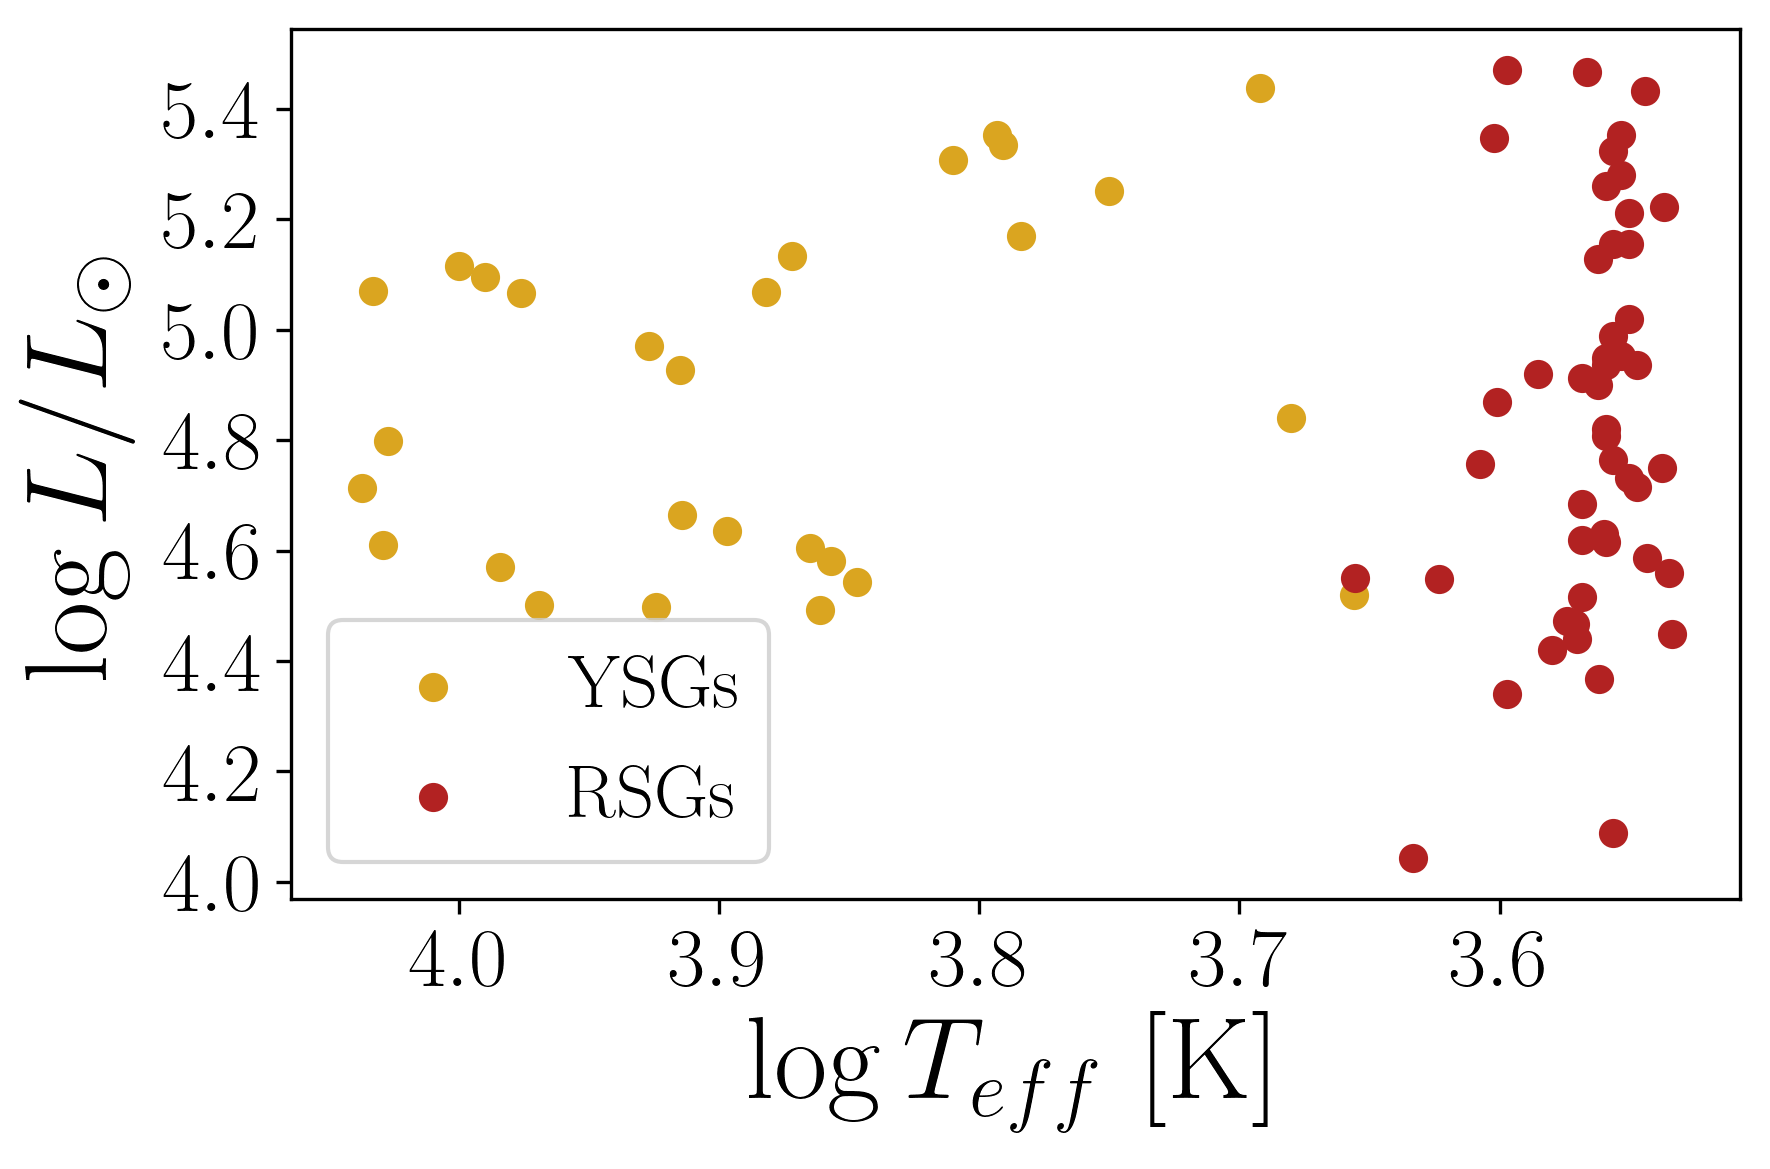

In [8]:
fig = plt.figure(dpi=300)
plt.scatter(ysg_spec['teff'],ysg_spec['lum'],c='goldenrod',label='YSGs')
plt.scatter(rsg_spec['teff'],rsg_spec['lum'],c='firebrick',label='RSGs')
plt.gca().invert_xaxis()

plt.legend(fontsize=18)

plt.xlabel('$\log{T_{eff}}$ [K]')
plt.ylabel('$\log{L/L_\odot}$')

ax= plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

plt.tight_layout()
plt.savefig('../plots/cool_sg.pdf')

# All these stars have TESS obervations, so let's look at them!

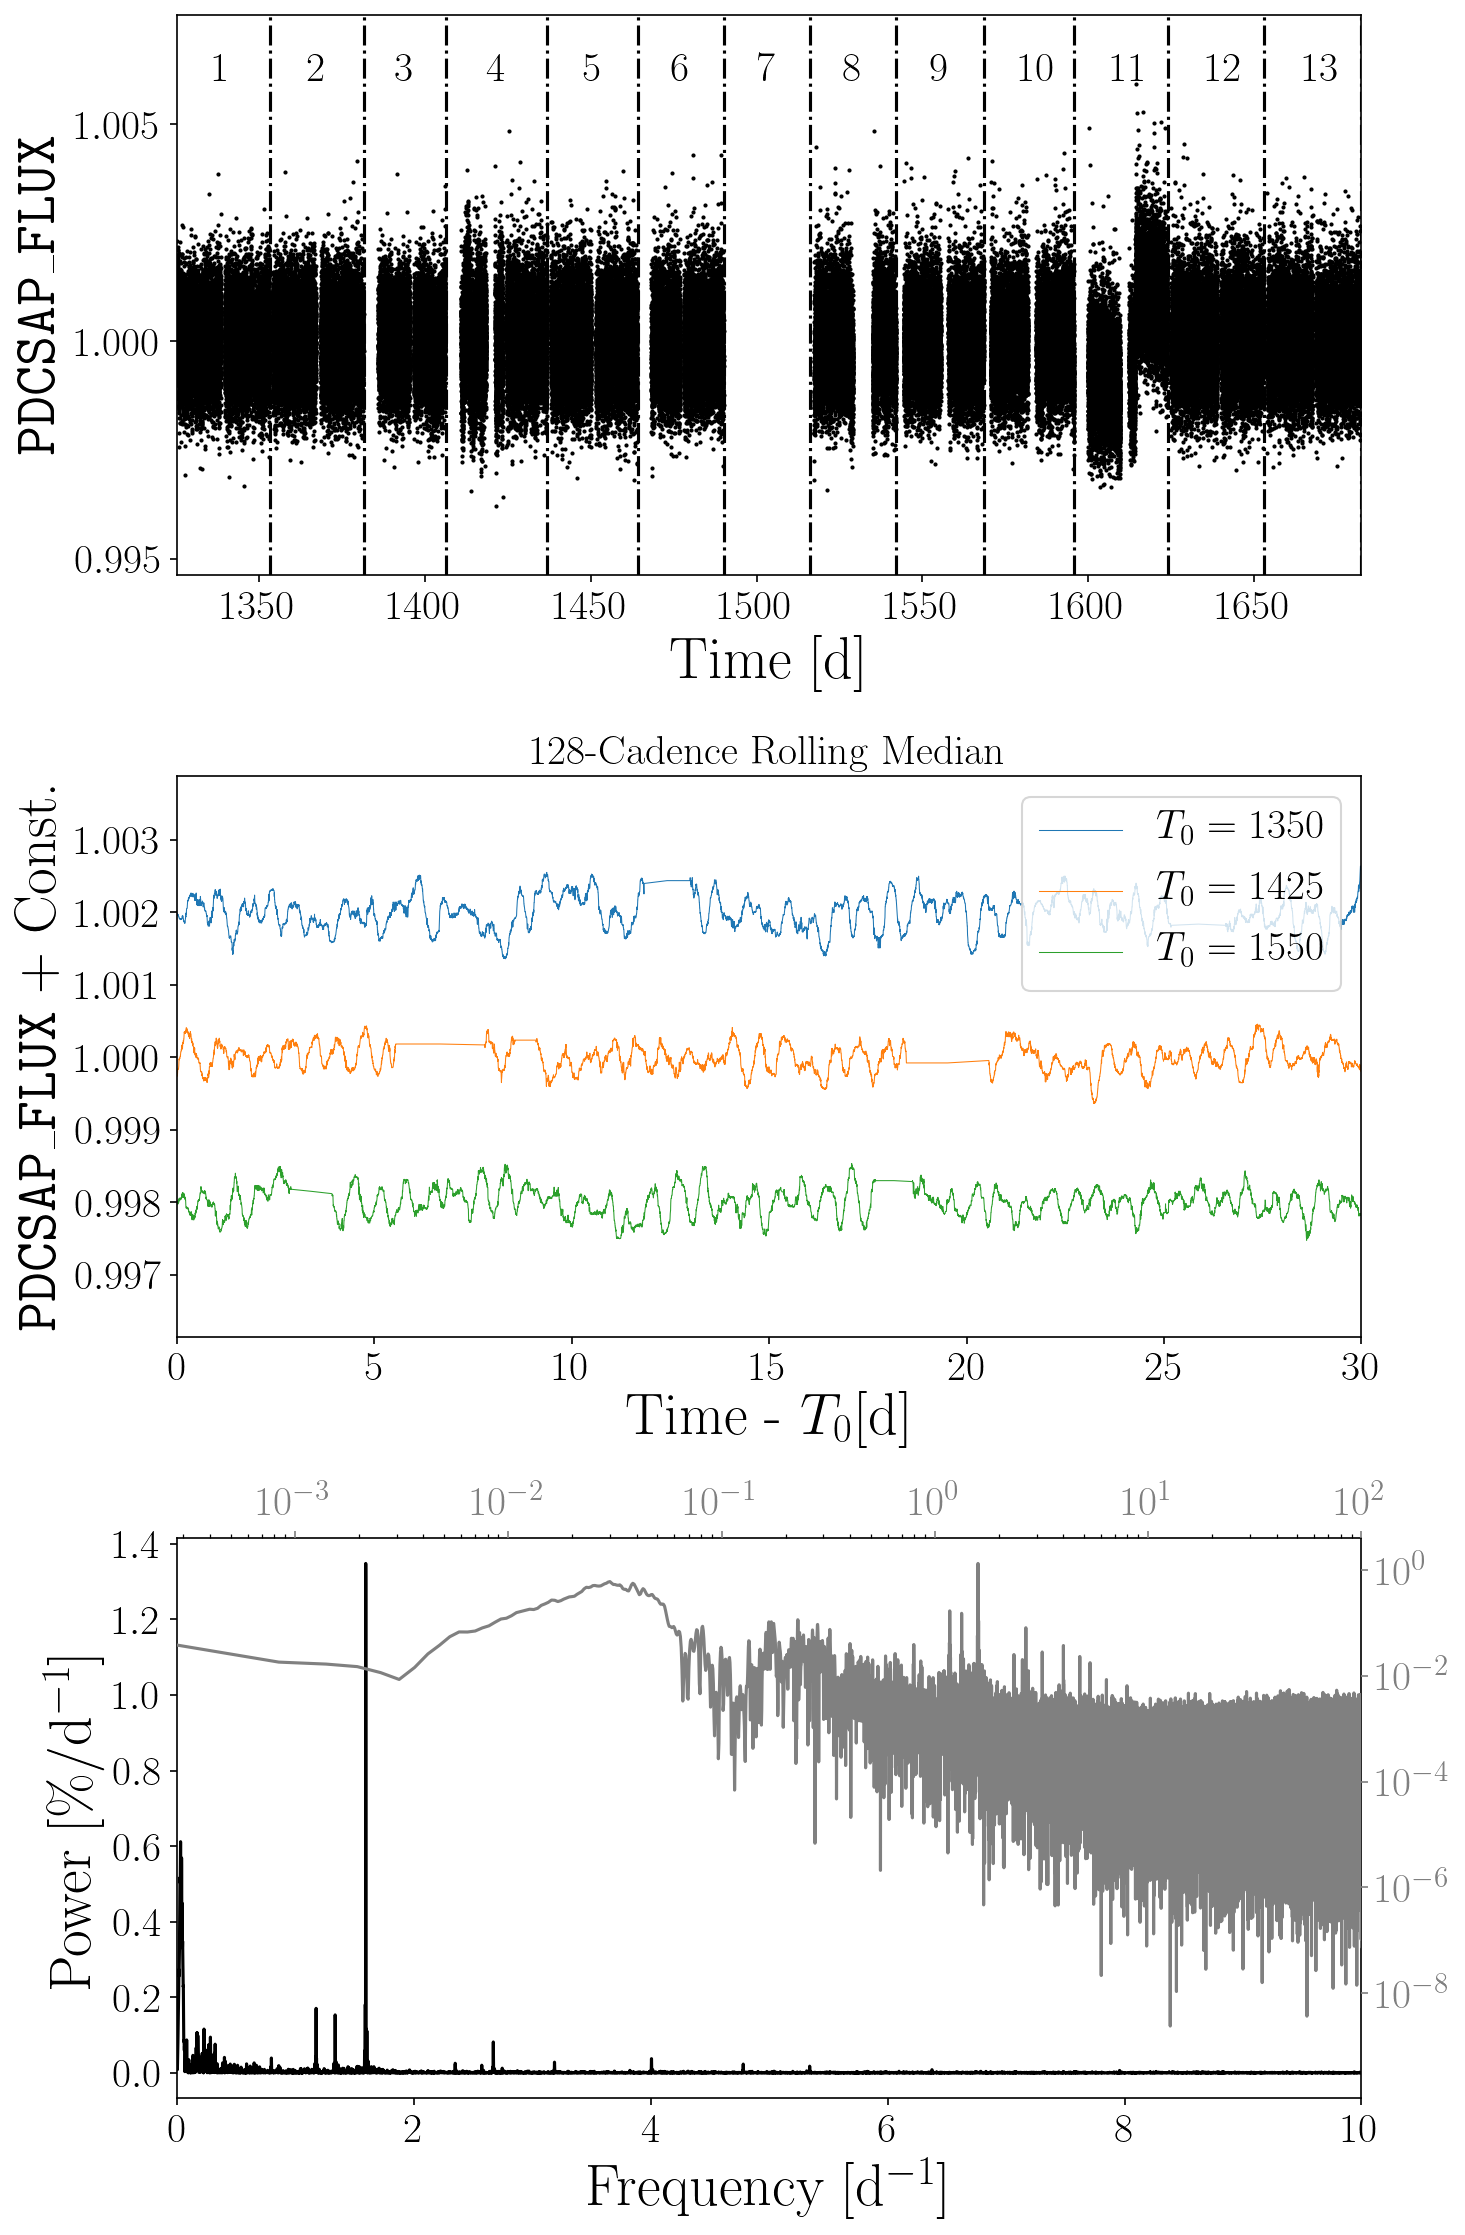

In [9]:
test_star = cool_sgs[cool_sgs['CommonName'] == 'HD 269953']
tic = test_star['TIC ID'].values[0]

lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
sap_lc = get_lc_from_id(tic)
sap_lc.dropna(subset=['TIME','SAP_FLUX','SAP_BKG','SAP_FLUX_ERR','SAP_BKG_ERR'],inplace=True)
sap_lc.sort_values('TIME',inplace=True)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time,flux,dy=err)
ls_short = LombScargle(sap_lc['TIME'],sap_lc['SAP_FLUX'],dy=sap_lc['SAP_FLUX_ERR'])
freq,power=ls.autopower(normalization='psd')
power /= len(time)
freq_s, power_s = ls_short.autopower(normalization='psd')
power_s /= len(sap_lc)

fig, axes = plt.subplots(3,figsize=(10,15),dpi=150)

sector_boundaries = np.array([1325.293, 1353.178, 1381.515, 1406.292, 1436.849, 1464.400, 1490.044,
                     1516.085, 1542.000, 1568.475, 1595.680, 1623.891, 1652.891, 1682.357])

sector_midpoints = sector_boundaries[:-1] + 0.5*np.diff(sector_boundaries)

axes[0].scatter(time, flux, c='k', s=1,rasterized=True)
axes[0].set(xlabel='Time [d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$',xlim=(time.min(),time.max()))
for s in sector_boundaries[1:]:
    axes[0].axvline(x=s,c='k',ls='-.')
for i,m in enumerate(sector_midpoints):
    axes[0].text(m-3,1.006,str(i+1),fontsize=20)
axes[0].set_yticks([0.995,1,1.005])

axes[1].plot(lc_smooth['Time']-1425, lc_smooth['Flux']+0.002, c='C0', label='$T_0 = 1350$',lw=0.5,rasterized=True)
axes[1].plot(lc_smooth['Time']-1550, lc_smooth['Flux'], c='C1', label='$T_0 = 1425$',lw=0.5,rasterized=True)
axes[1].plot(lc_smooth['Time']-1650, lc_smooth['Flux']-0.002, c='C2', label='$T_0 = 1550$',lw=0.5,rasterized=True)

axes[1].set(xlabel='Time - $T_0$[d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$ + Const.', xlim=(0,30))#,ylim=(0.9985,1.0015))
axes[1].set_title('128-Cadence Rolling Median',fontsize=20)
#axes[1].set_yticks(ticks=[0.999,1,1.001])
#axes[1].set_yticklabels([0.999,1.0000,1.001])
axes[1].legend(loc = 'upper right',fontsize=20)

logax = fig.add_subplot(313, label="1", frame_on=False)
logax.set(xlim=(freq.min(),1e2))
logax.loglog(freq,power*100,c='grey',rasterized=True)
#logax.loglog(freq_s,power_s*100,c='r',alpha=0.5,rasterized=True)
logax.tick_params(axis='x', colors='grey')
logax.tick_params(axis='y', colors='grey')
logax.xaxis.set_label_position('top') 
logax.yaxis.set_label_position('right') 
logax.xaxis.tick_top()
logax.yaxis.tick_right()
logax.set_yticks([10**i for i in [-8,-6,-4,-2,0]])
logax.set_yticklabels([f'$10^{{{i}}}$' for i in [-8,-6,-4,-2,0]],fontdict={'fontsize':20})
logax.set_xticks([10**i for i in [-3,-2,-1,0,1,2]])
logax.set_xticklabels([f'$10^{{{i}}}$' for i in [-3,-2,-1,0,1,2]],fontdict={'fontsize':20})

axes[2].plot(freq,power*100,c='k')
#axes[2].plot(freq_s,power_s*100,c='r')
axes[2].set(xlabel='Frequency [d$^{-1}$]',ylabel=r'Power [$\%$/d$^{-1}$]',xlim=(0,10))

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
plt.tight_layout()
    
plt.savefig('../plots/hd269953_example.pdf')

In [10]:
cool_sgs['CommonName'].values

array(['V* V1092 Cen', 'V* HS Cas', 'HD 143183', 'BD+35  4077',
       'V* AD Per', 'V* KY Cyg', 'TYC 8626-2180-1', 'V* V589 Cas',
       'V* RS Per', 'V* V602 Car', 'V* W Per', 'V* V396 Cen', 'V* BI Cyg',
       'V* BC Cyg', 'V* SU Per', 'V* PZ Cas', 'V* ST Cep', 'V* RW Cyg',
       'V* TZ Cas', 'V* BU Per', 'V* V349 Car', 'V* V774 Cas',
       'HD  95687', 'V* V441 Per', 'HD 303250', 'V* RT Car',
       'V* V772 Cen', 'HD 101007', 'V* V648 Cas', 'V* IX Car', 'V* W Cep',
       'V* V910 Cen', 'V* V528 Car', 'V* YZ Per', 'V* V362 Aur',
       'V* PR Per', 'V* FZ Per', 'V* V809 Cas', 'V* V439 Per',
       'V* V605 Cas', '*  41 Gem', 'V* RW Cep', 'HD 155603', 'V* NR Vul',
       'V* QY Pup', 'HD  17958', 'HD  33299', 'V* AZ Cas', 'SK -67   57',
       'SV* HV   883', 'HD 269953', 'HD 269110', 'HD 268687', 'HD 269840',
       'HD 269902', 'HD 269331', 'RMC 137', 'CPD-69   430', 'W61 27-27',
       'HD 269392', 'HD 269128', 'HD 269700', 'HD 270151', 'CPD-69   491',
       'HD 270754', 'HD 

## What about all of their periodograms?

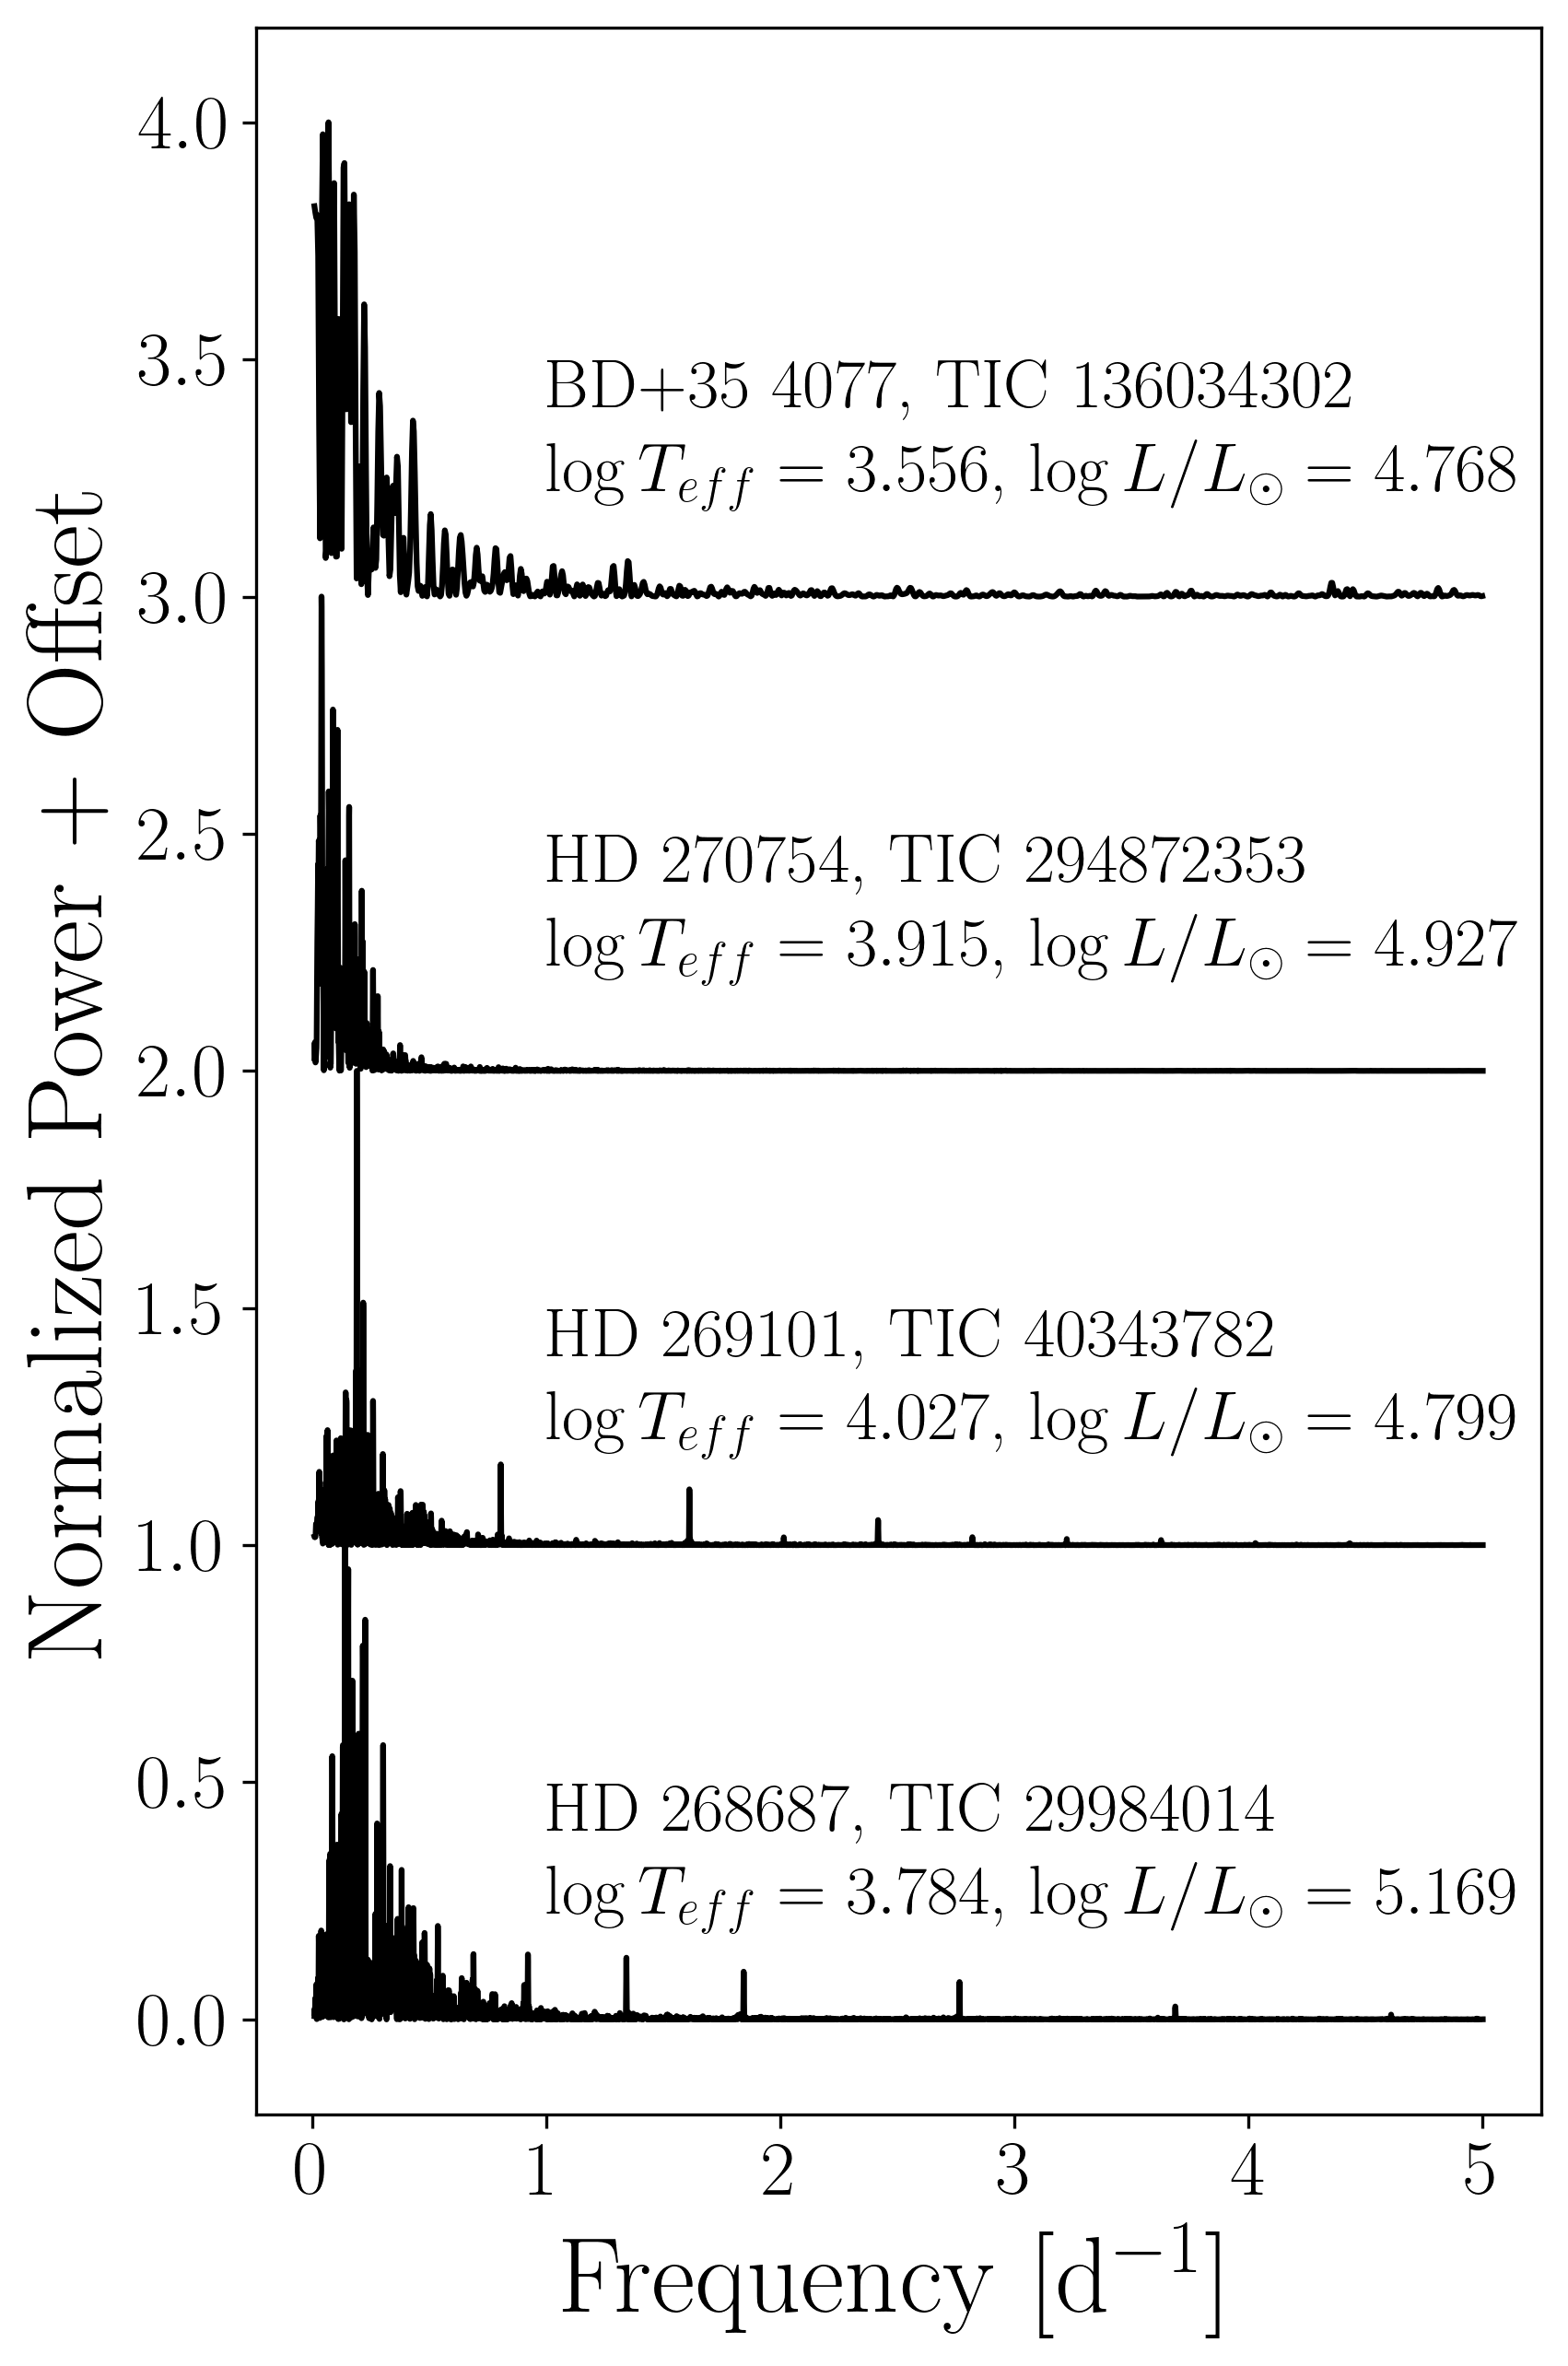

In [11]:
rep_acyg = aceps.iloc[0]
rep_fyps = fyps.iloc[2]
rep_warm = cool_sgs[(cool_sgs['teff'] >= 3.9)&(cool_sgs['teff'] <= 4)&(cool_sgs['lum']>= 4.9)&(cool_sgs['lum']<=5.0)].iloc[0]
rep_cool = cool_sgs[(cool_sgs['teff'] <= 3.6)&(cool_sgs['lum']>= 4.7)&(cool_sgs['lum']<=4.8)].iloc[0]
offset = 0
fig = plt.figure(figsize=(6,10), dpi=300)
for rep in [rep_cool,rep_warm,rep_acyg,rep_fyps][::-1]:
    lc, lc_smooth = lc_extract(get_lc_from_id(rep['TIC ID']), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    ls = LombScargle(time,flux,dy=err)
    freq,power=ls.autopower(minimum_frequency=0.01,maximum_frequency=5,normalization='psd')
    power /= len(time)
    plt.plot(freq,power/power.max()+offset,c='k',rasterized=True)
    plt.text(1, 0.4   +offset, f"{rep['CommonName']}, TIC {rep['MatchID']}",fontsize=18)
    plt.text(1, 0.2 +offset, f"$\log T_{{eff}} = {rep['teff']:.3f}$, $\log L/L_{{\odot}} = {rep['lum']:.3f}$",fontsize=18)
    offset += 1
plt.xlabel('Frequency [d$^{-1}$]')
plt.ylabel('Normalized Power + Offset')

ax = plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
plt.savefig('../plots/representative_periodograms.pdf',bbox_inches='tight')

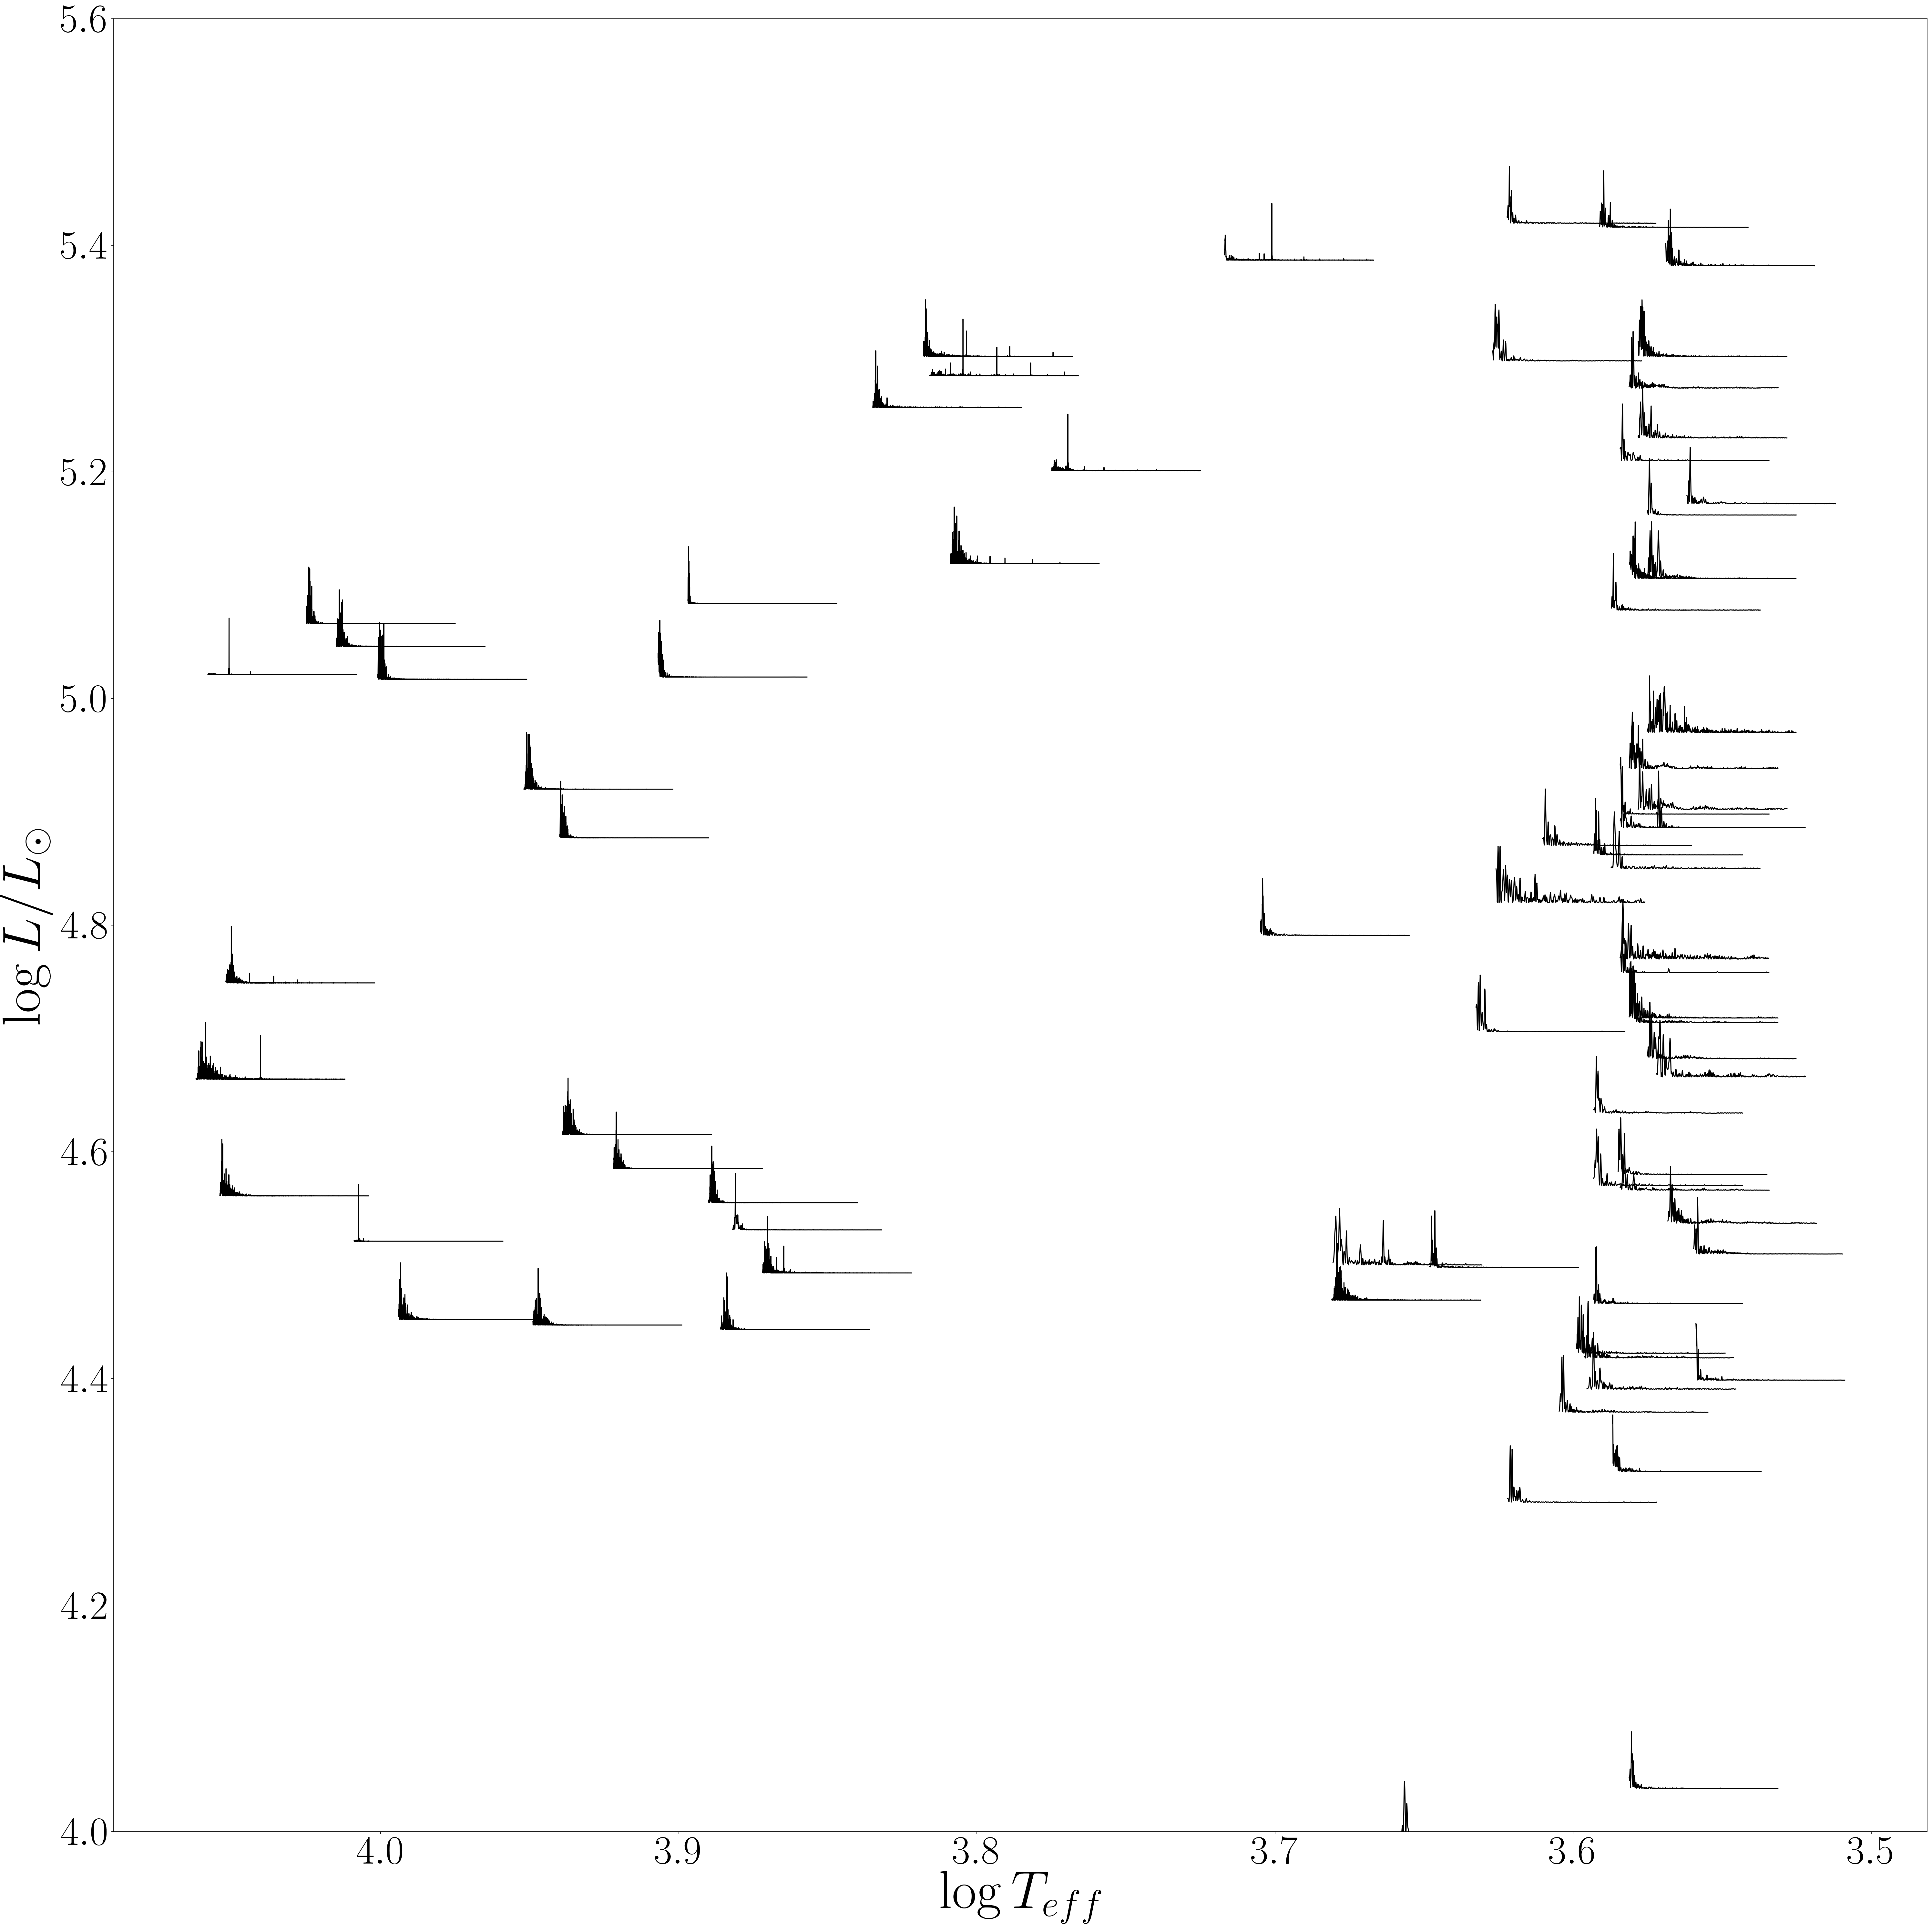

In [12]:
fig = plt.figure(figsize=(40,40),dpi=150)
for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
    lc, lc_smooth = lc_extract(get_lc_from_id(star['TIC ID']), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    ls = LombScargle(time,flux,dy=err)
    freq,power=ls.autopower(minimum_frequency=0.01,maximum_frequency=5,normalization='psd')
    power /= len(time)
    x = star['teff']
    y = star['lum']
    plt.plot(0.01*(-freq + 2.5) + x,0.05*(power/power.max()) - 0.05 + y,c='k')
    #plt.text(x-0.005, y,star['CommonName'].lstrip('V*').lstrip(),fontdict={'fontsize':20})
ax = plt.gca()
ax.invert_xaxis()
ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',ylim=(4.0,5.6))
ax.xaxis.label.set_size(80)
ax.yaxis.label.set_size(80)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(60)
    
plt.tight_layout()
plt.savefig('../plots/periodogram_hr.pdf')

CommonName    HD 269331
teff               3.81
lum               5.307
Tmag            10.1142
Name: 55, dtype: object
     teff    lum     Tmag
50  3.692  5.437   9.2671
51  3.750  5.251  10.0380
52  3.784  5.169  10.4649
53  3.791  5.335  10.1320
54  3.793  5.352   9.7899
[0.02326641 0.52947631 1.69572127 0.00175383]


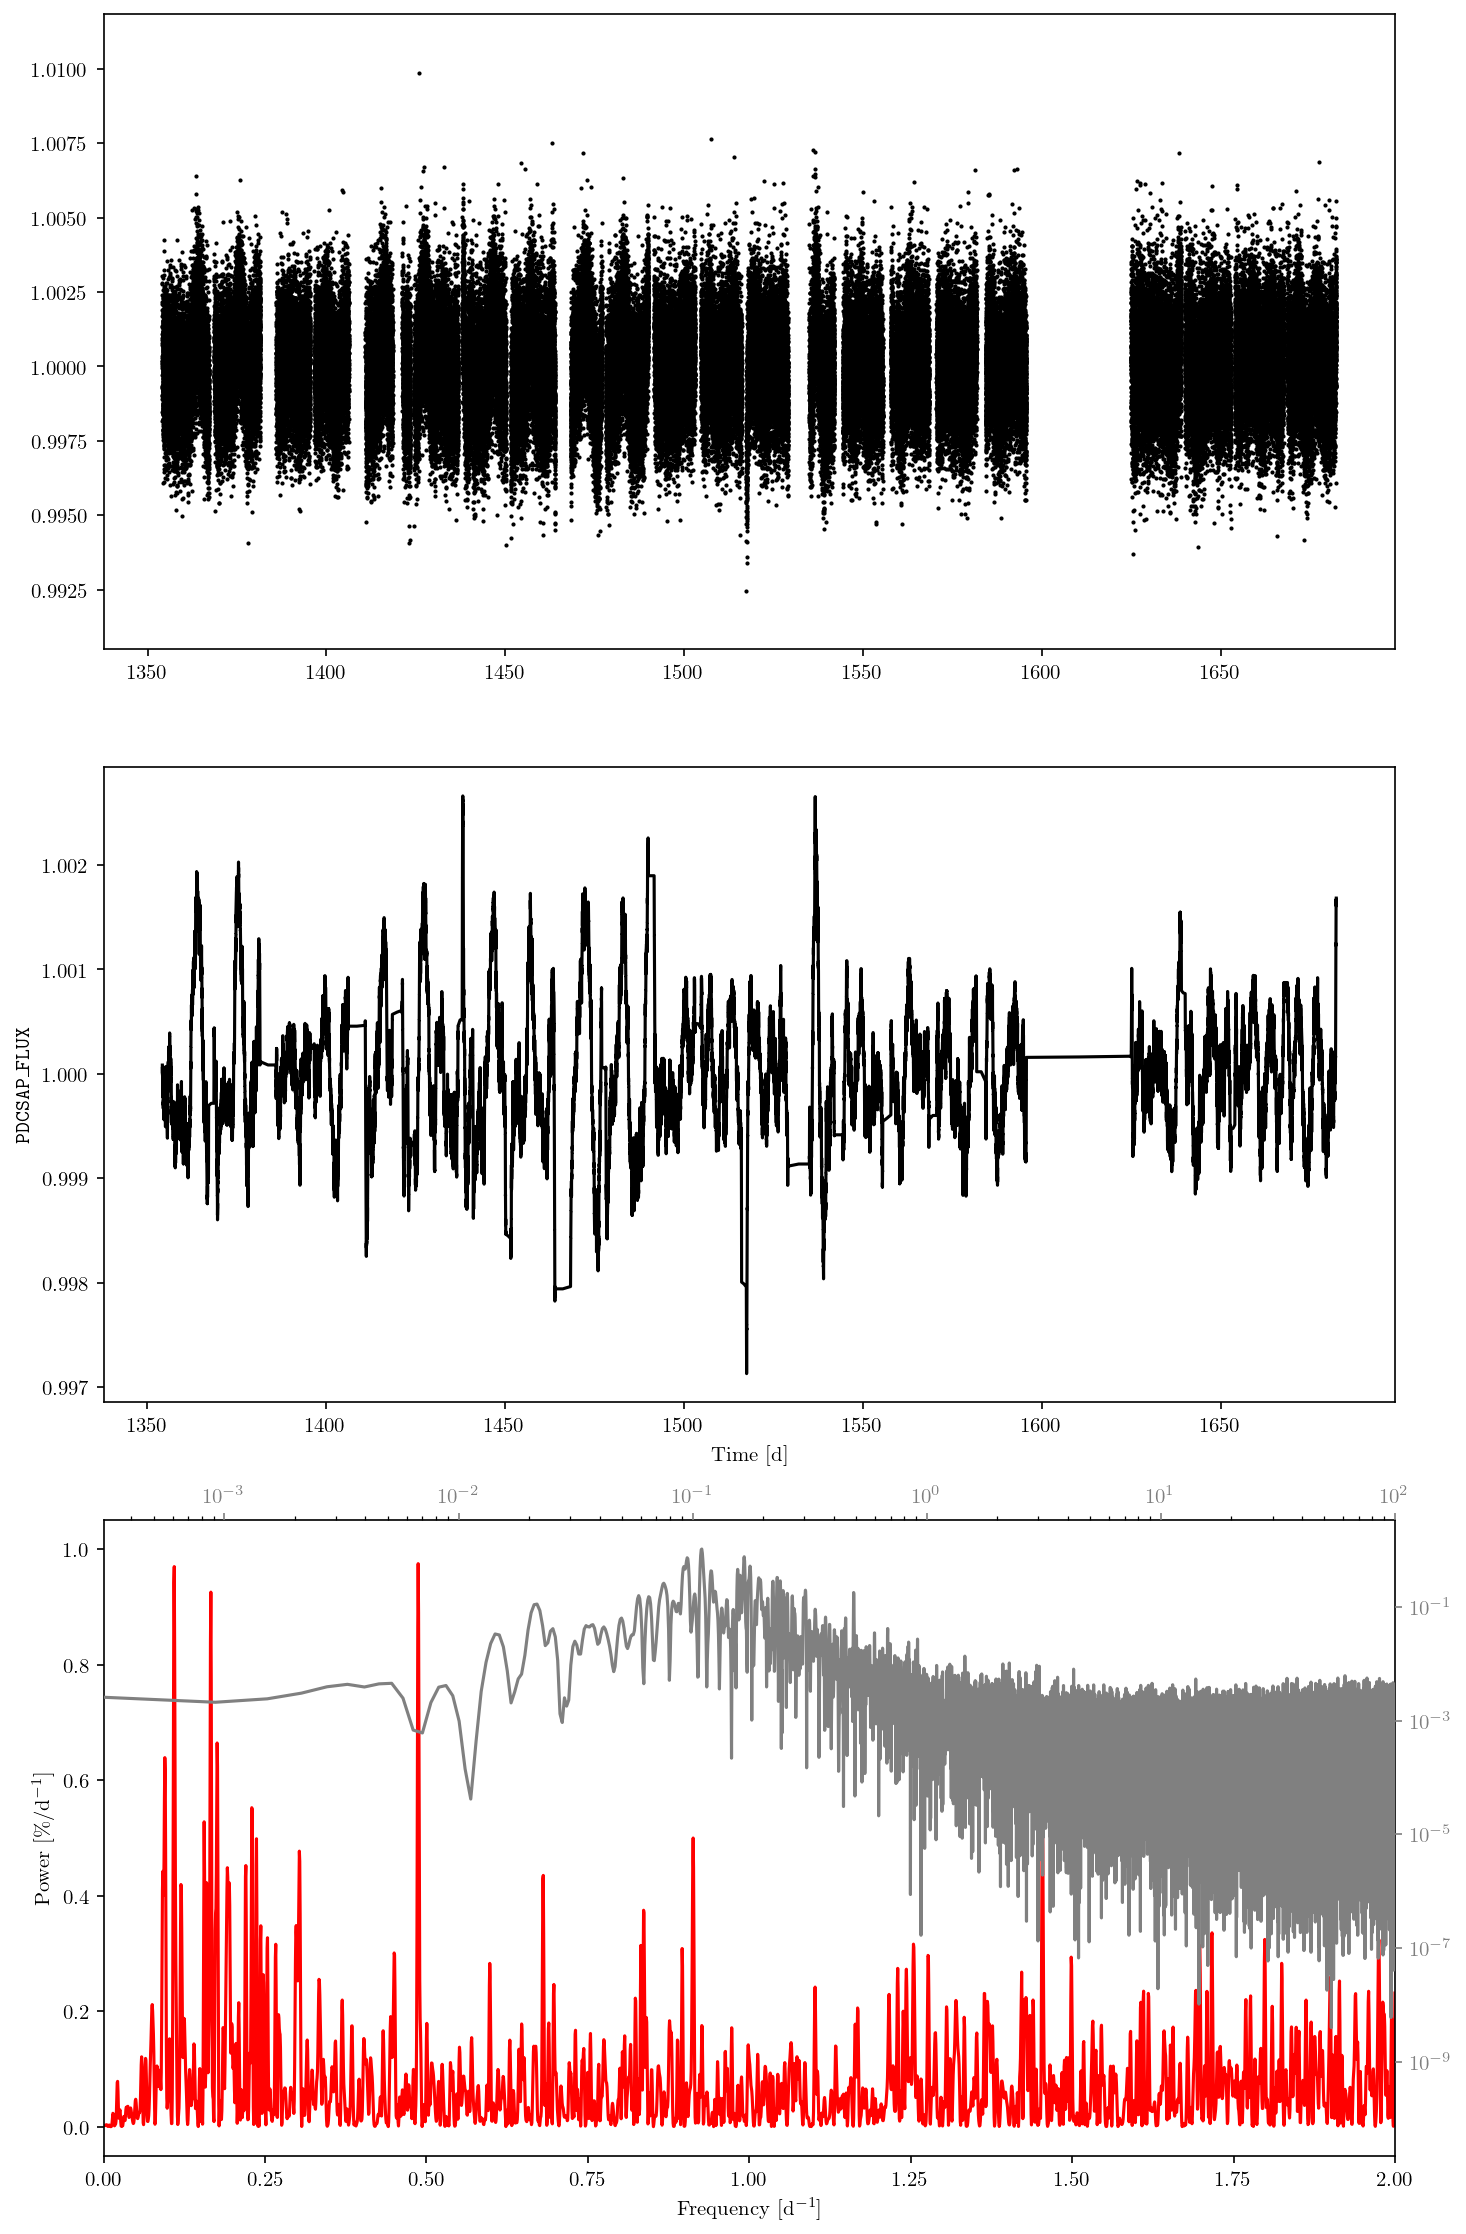

In [150]:
test_star = cool_sgs[(cool_sgs['teff'] >= 3.8)&(cool_sgs['lum']>= 5.1)&(cool_sgs['lum']<=5.5)].iloc[0]
print(test_star[['CommonName','teff','lum','Tmag']])
print(fyps[['teff','lum','Tmag']])
tic = test_star['TIC ID']

lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time,flux,dy=err)
freq,power=ls.autopower(normalization='psd',maximum_frequency=600)
power /= len(time)
popt, pcov, resid = fit_red_noise(freq, power)
print(popt)

fig, axes = plt.subplots(3,figsize=(10,15),dpi=150)

axes[0].scatter(time, flux, c='k', s=1, label='Flux',rasterized=True)


axes[1].plot(lc_smooth['Time'], lc_smooth['Flux'], c='k', label='128-cadence Rolling Median',rasterized=True)
axes[1].set(xlabel='Time [d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$')#, xlim=(1460,1500))

logax = fig.add_subplot(313, label="1", frame_on=False)
logax.set(xlim=(freq.min(),1e2))
logax.loglog(freq,power*100,c='grey',rasterized=True)
logax.tick_params(axis='x', colors='grey')
logax.tick_params(axis='y', colors='grey')
logax.xaxis.set_label_position('top') 
logax.yaxis.set_label_position('right') 
logax.xaxis.tick_top()
logax.yaxis.tick_right()

#axes[2].plot(freq,power*100,c='k')
axes[2].plot(freq,resid/resid.max(),c='r')
axes[2].set(xlabel='Frequency [d$^{-1}$]',ylabel=r'Power [$\%$/d$^{-1}$]',xlim=(0,2))
    
plt.tight_layout()

   CommonName   teff    lum     Tmag
74  HD 268798  4.033  5.071  10.1029
     teff    lum     Tmag
50  3.692  5.437   9.2671
51  3.750  5.251  10.0380
52  3.784  5.169  10.4649
53  3.791  5.335  10.1320
54  3.793  5.352   9.7899
[0.28974795 0.59796563 1.39629232 0.00225772]


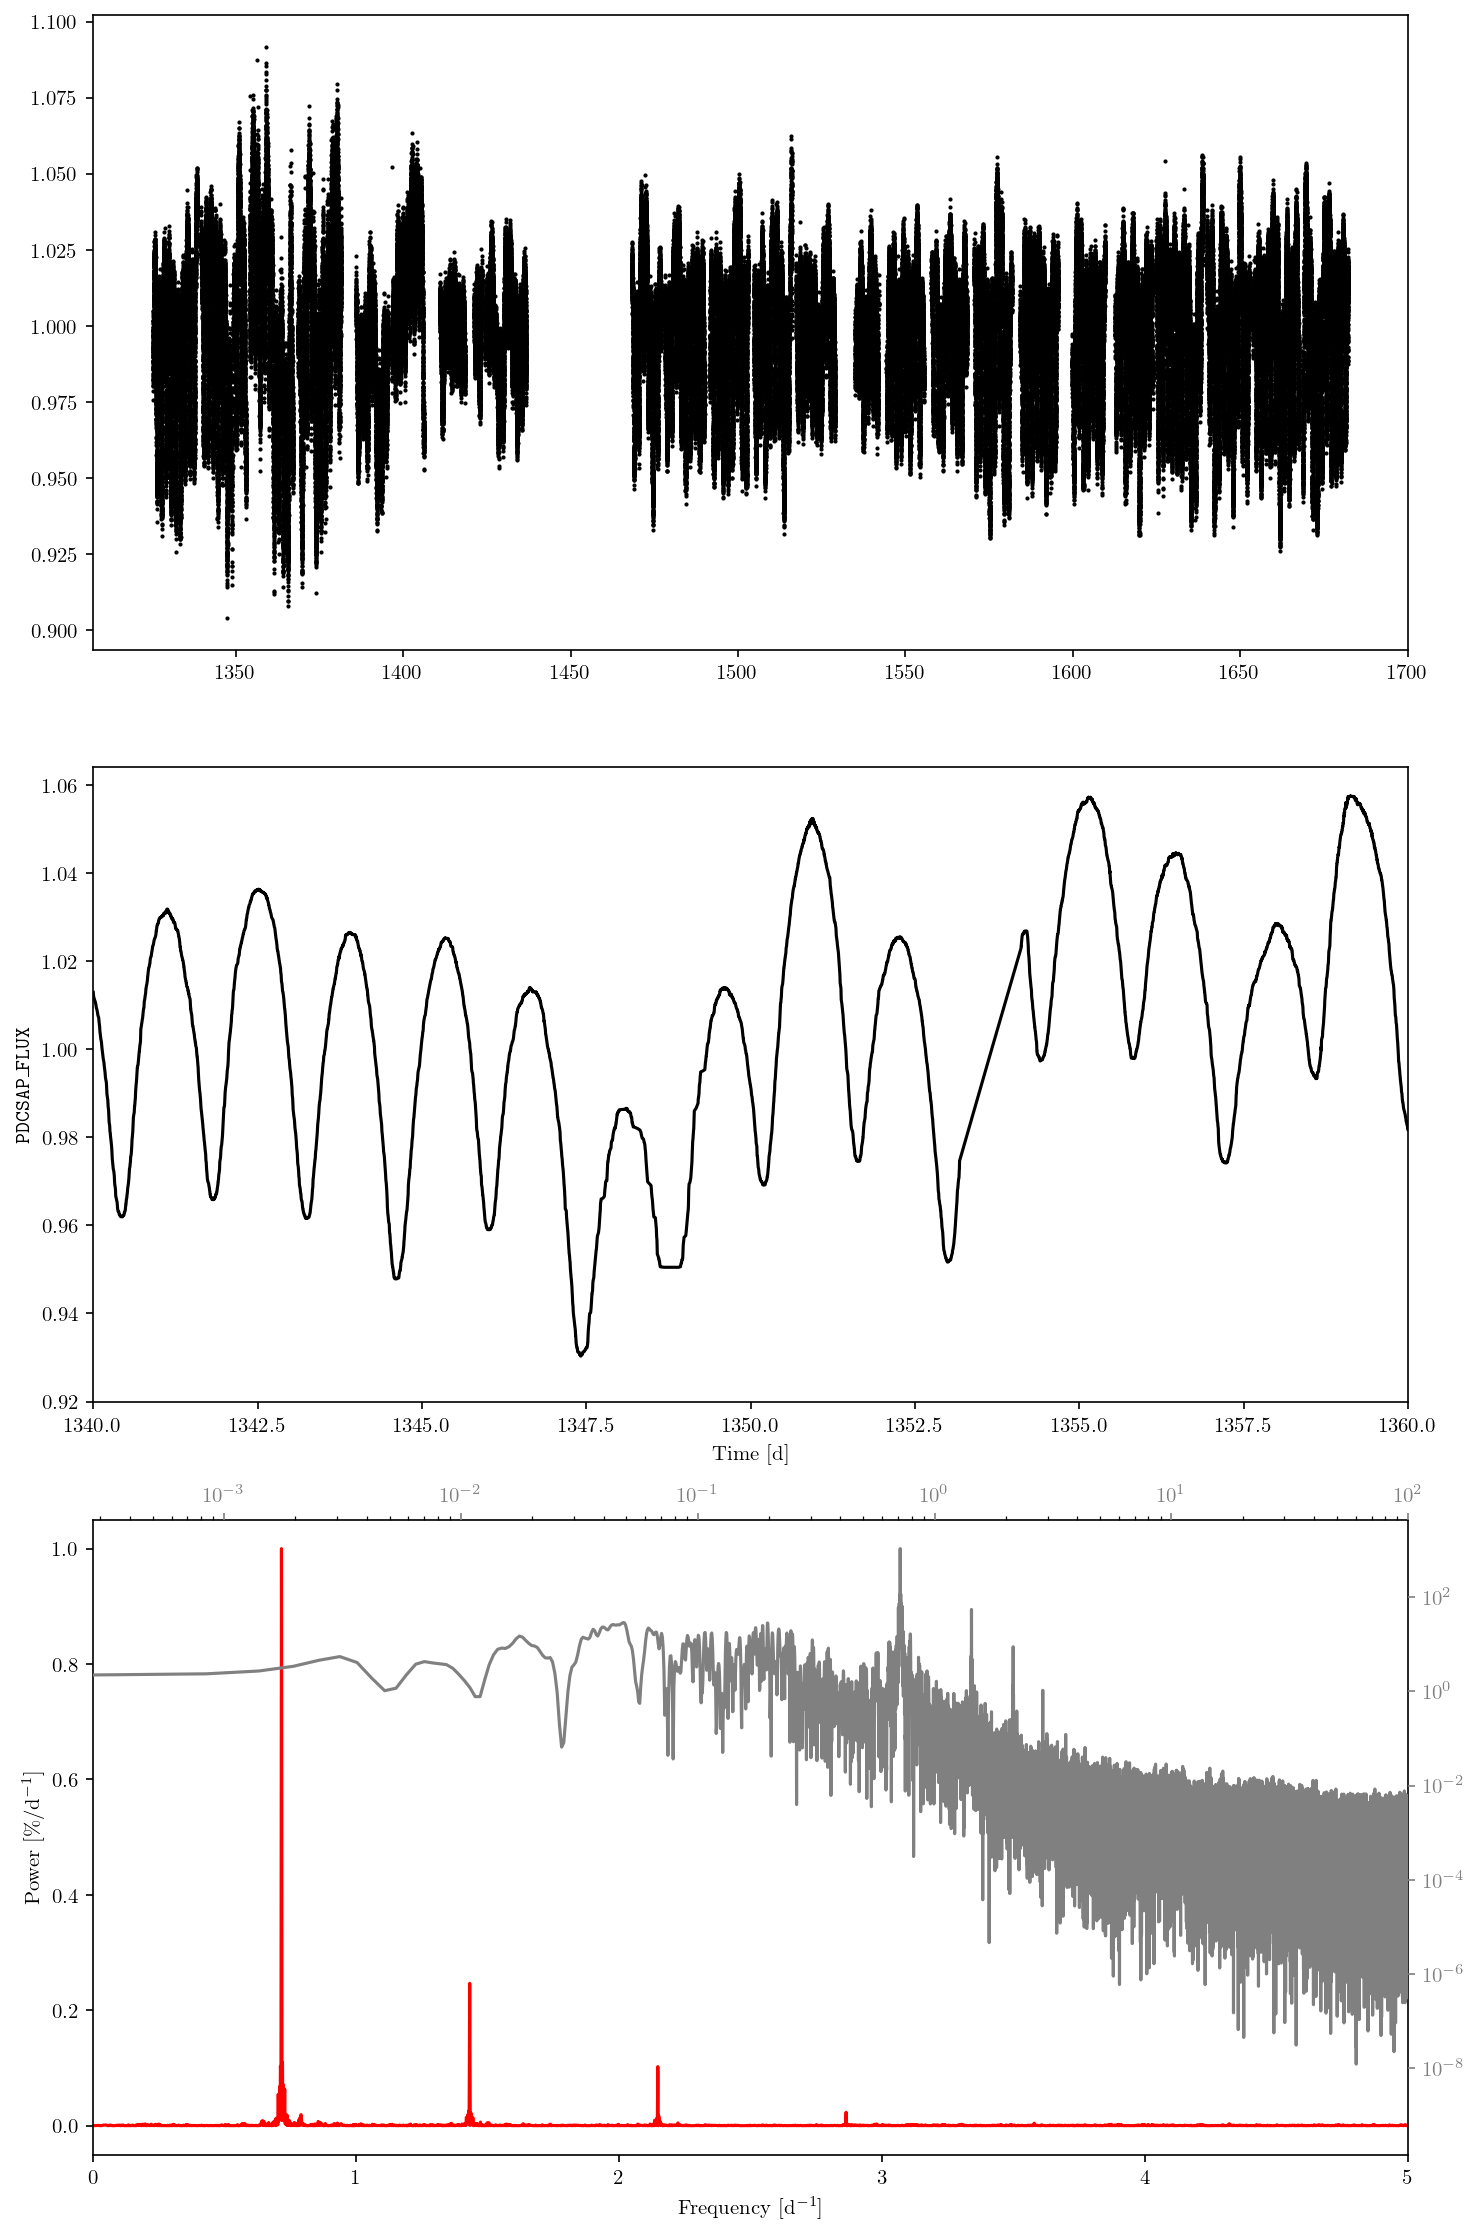

In [171]:
test_star = cool_sgs[cool_sgs['CommonName']=='HD 268798']
print(test_star[['CommonName','teff','lum','Tmag']])
print(fyps[['teff','lum','Tmag']])
tic = test_star['TIC ID'].values[0]

lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time,flux,dy=err)
freq,power=ls.autopower(normalization='psd',maximum_frequency=600)
power /= len(time)
popt, pcov, resid = fit_red_noise(freq, power)
print(popt)

fig, axes = plt.subplots(3,figsize=(10,15),dpi=150)

axes[0].scatter(time, flux, c='k', s=1, label='Flux',rasterized=True)


axes[1].plot(lc_smooth['Time'], lc_smooth['Flux'], c='k', label='128-cadence Rolling Median',rasterized=True)
axes[1].set(xlabel='Time [d]', ylabel=r'$\texttt{PDCSAP\_FLUX}$', xlim=(1340,1360))

logax = fig.add_subplot(313, label="1", frame_on=False)
logax.set(xlim=(freq.min(),1e2))
logax.loglog(freq,power*100,c='grey',rasterized=True)
logax.tick_params(axis='x', colors='grey')
logax.tick_params(axis='y', colors='grey')
logax.xaxis.set_label_position('top') 
logax.yaxis.set_label_position('right') 
logax.xaxis.tick_top()
logax.yaxis.tick_right()

#axes[2].plot(freq,power*100,c='k')
axes[2].plot(freq,resid/resid.max(),c='r')
axes[2].set(xlabel='Frequency [d$^{-1}$]',ylabel=r'Power [$\%$/d$^{-1}$]',xlim=(0,5))
    
plt.tight_layout()
plt.savefig('/Users/carina/Desktop/EB')

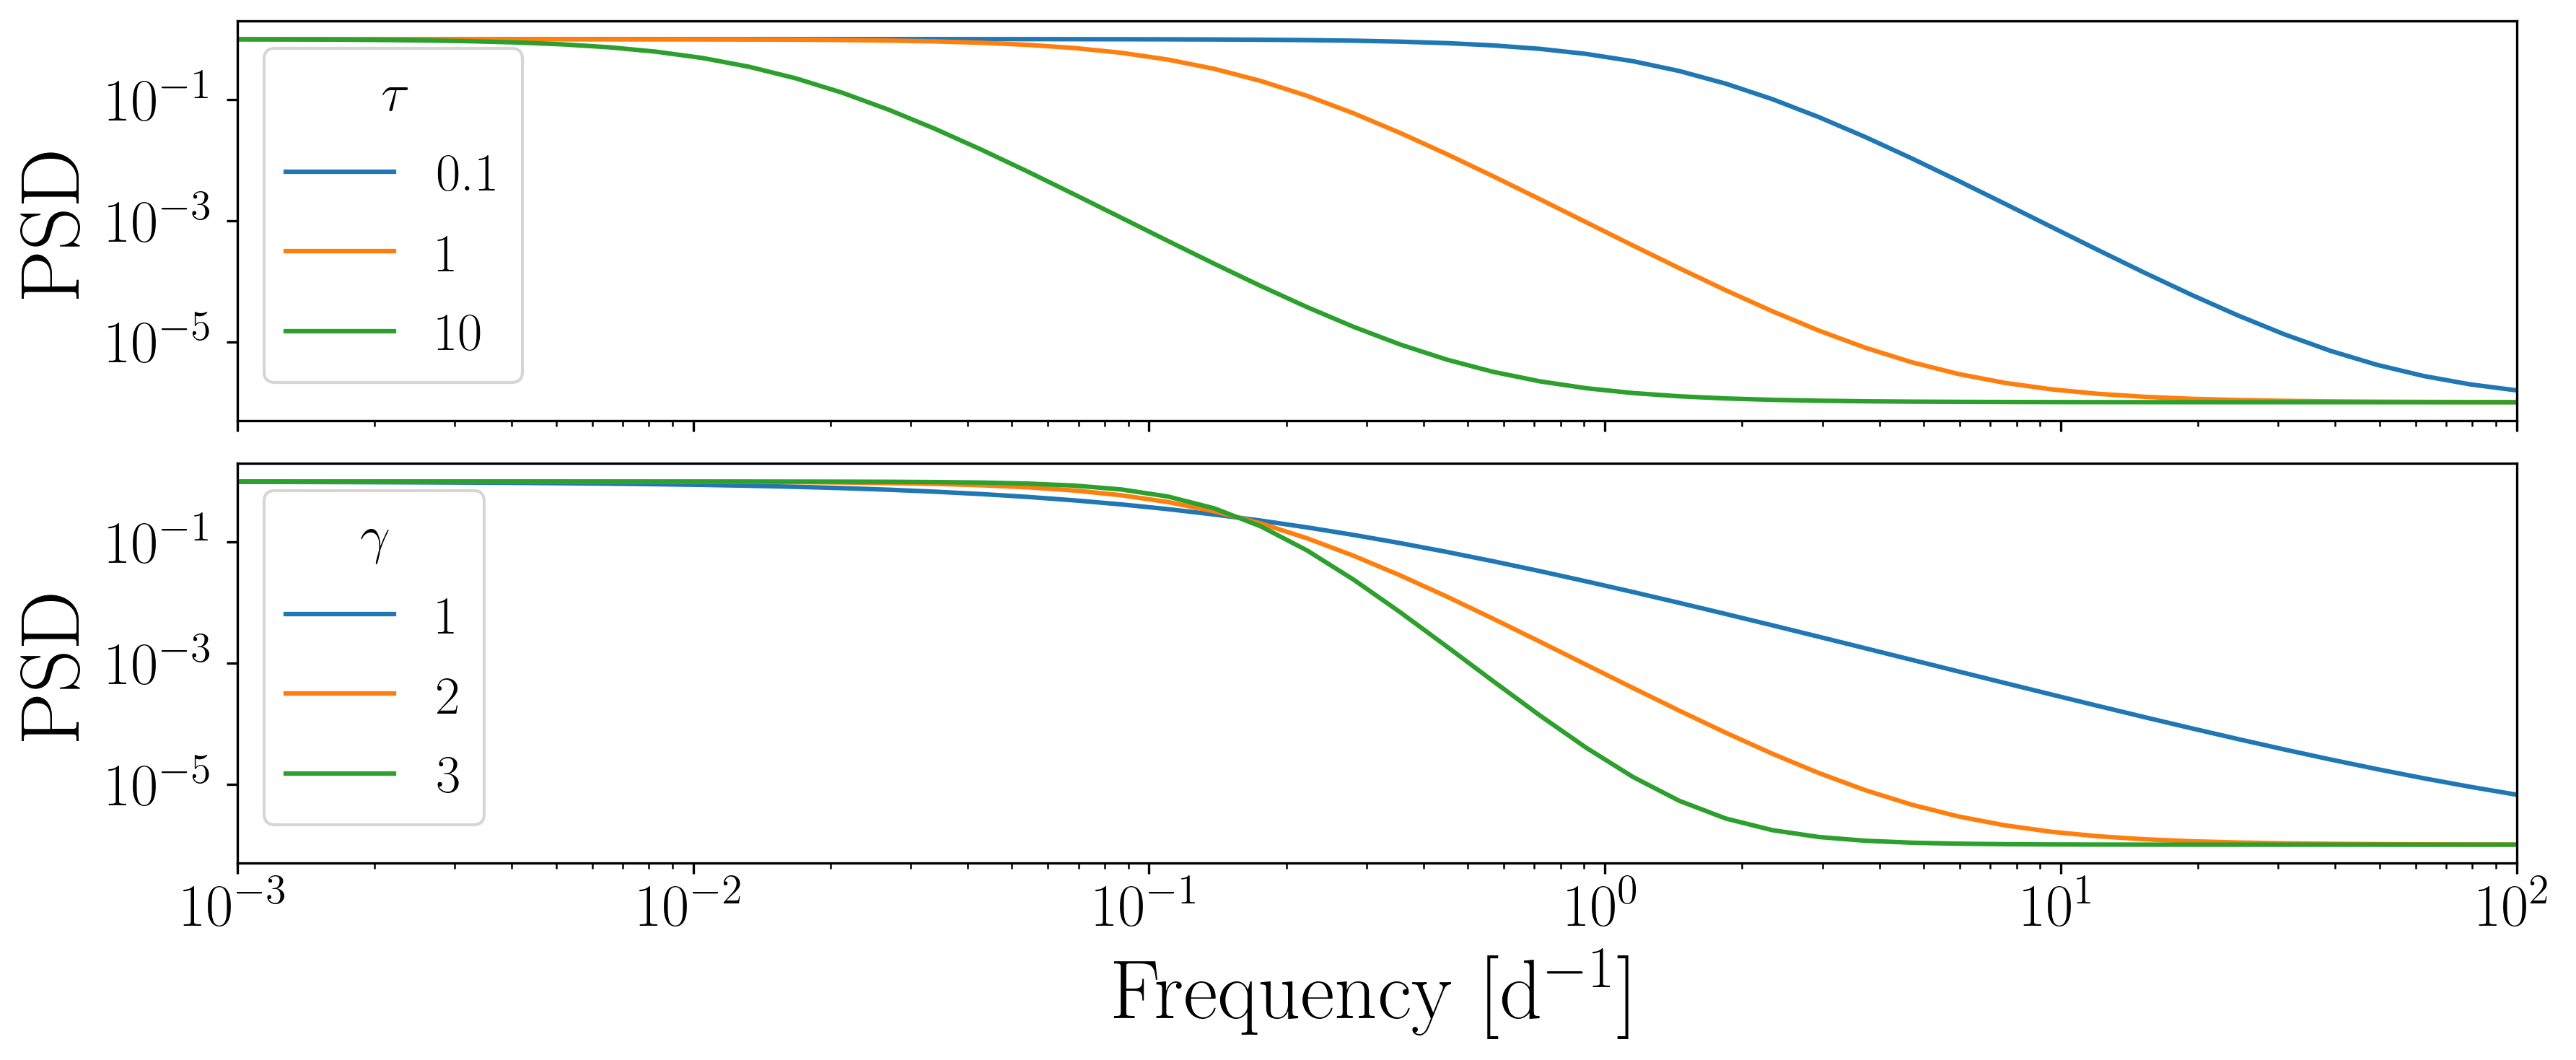

In [13]:
fig,axes = plt.subplots(2,figsize=(12,5),sharex=True,dpi=300)
fs = np.logspace(-3,2)
for tau in [0.1,1,10]:
    axes[0].loglog(fs,noise_func(fs,1,tau,2,1e-3)**2.0,label=tau)
    
for gamma in [1,2,3]:
    axes[1].loglog(fs,noise_func(fs,1,1,gamma,1e-3)**2.0,label=gamma)

axes[0].set(ylabel='PSD',xlim=(1e-3,1e2))
axes[1].set(xlabel='Frequency [d$^{-1}$]',ylabel='PSD',xlim=(1e-3,1e2))

leg1 = axes[0].legend(title=r'$\tau$',fontsize=18)
leg2 = axes[1].legend(title=r'$\gamma$',fontsize=18)

leg1.get_title().set_fontsize('18')
leg2.get_title().set_fontsize('18')

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/noise_func.pdf')

In [14]:
popts = []
errs = []
freqs = []
resids = []
import warnings
from tqdm.notebook import tqdm
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
        lc, lc_smooth = lc_extract(get_lc_from_id(star['TIC ID']), smooth=128)
        time, flux, err = lc['Time'], lc['Flux'], lc['Err']
        ls = LombScargle(time,flux,dy=err)
        freq,power=ls.autopower(normalization='psd')
        power /= len(time) #correct units
        try:
            popt, pcov, resid = fit_red_noise(freq, power)
        except RuntimeError:
            popt, pcov, resid = fit_red_noise(freq[freq < 50], power[freq < 50])
            freq = freq[freq < 50]
        popts.append(popt)
        errs.append(np.sqrt(np.diag(pcov)))
        frequency_range = (freq >= 0.1) & (freq <= 5)
        resid_range = resid[frequency_range]
        freq_range = freq[frequency_range]
        freqs.append(freq_range)
        resids.append(resid_range)

In [15]:
popts = np.array(popts)
errs = np.array(errs)
freqs = np.array(freqs)
resids = np.array(resids)
alphas = popts[:,0]
ealphas = errs[:,0]
taus = popts[:,1]
etaus = errs[:,1]
gammas = popts[:,2]
egammas = errs[:,2]
alpha_w = popts[:,3]
ealpha_w = errs[:,3]

cool_sgs['alpha'] = alphas
cool_sgs['e_alpha'] = ealphas
cool_sgs['tau'] = taus
cool_sgs['e_tau'] = etaus
cool_sgs['gamma'] = gammas
cool_sgs['e_gamma'] = egammas
cool_sgs['alpha_w'] = alpha_w
cool_sgs['e_alpha_w'] = ealpha_w
cool_sgs.to_csv('cool_supergiants_TESS.csv',index=False)

In [17]:
gammas

array([1.75467526, 1.78443443, 1.60108325, 1.5443498 , 2.26765652,
       1.35926845, 1.45578824, 2.14200309, 1.65437564, 2.16548949,
       2.44954585, 1.5974085 , 1.47750559, 1.28366963, 2.09926677,
       1.59625028, 1.55694747, 1.40645893, 1.88624098, 2.3713501 ,
       1.56209954, 1.72100009, 1.37544513, 2.41214405, 1.79794414,
       1.52875618, 2.6548948 , 1.5919799 , 1.95569189, 1.54914095,
       1.71943997, 1.89597623, 1.62660976, 2.34170131, 1.53356449,
       1.90671593, 2.38336742, 1.63790037, 2.0375161 , 1.81084144,
       2.10433564, 1.84160257, 1.99913532, 1.38423542, 1.32565828,
       1.52745852, 1.68661585, 3.03479203, 2.414549  , 1.39953175,
       1.52728793, 1.9449548 , 1.97399715, 2.30277846, 1.73858742,
       1.73387954, 1.8974615 , 1.73619196, 1.68766955, 1.57929302,
       1.29441665, 1.28298985, 1.44474438, 1.57837451, 1.38094616,
       1.4877364 , 1.59783513, 1.84472709, 1.42909886, 1.26084971,
       1.66729797, 1.31137277, 1.91878922, 1.61553545, 1.51117

In [23]:
header = r"""\centerwidetable
\begin{deluxetable*}{lccccc}
\tabletypesize{\scriptsize}
\tablecaption{Names, TIC numbers, fit parameters from Equation \eqref{eq:rednoise}, and corresponding errors for all stars in our sample.\label{tab:fit_params}}
\tablehead{\colhead{Common Name} & \colhead{TIC Number} & \colhead{$\alpha_0$} & \colhead{$\tau$} & \colhead{$\gamma$} & \colhead{$\alpha_w$} \\
\colhead{} & \colhead{}  & \colhead{ppt} & \colhead{d} & \colhead{} & \colhead{ppt} } 
\startdata
"""
for i,row in cool_sgs.iterrows():
    name = row['CommonName'].lstrip('V*')
    if name[0:2] == 'SV':
        name = name.lstrip('SV*')
    tic = row['MatchID']
    a0 = f"${row['alpha']*1e3:.4f} \pm {row['e_alpha']*1e3:.4f}$"
    tau = f"${row['tau']:.4f} \pm {row['e_tau']:.4f}$"
    gamma = f"${row['gamma']:.3f} \pm {row['e_gamma']:.3f}$"
    aw = f"${row['alpha_w']*1e3:.4f} \pm {row['e_alpha_w']*1e3:.4f}$"
    entry = list(map(str,[name,tic,a0,tau,gamma,aw]))
    
    sep = ' & '
    
    header += sep.join(entry)
    header += ' \\\\ \n'
header.rstrip()
header.rstrip('\\')
header.rstrip()
header += r"""\enddata
\end{deluxetable*}

"""
with open("Table2.tex", "w") as text_file:
        text_file.write(header)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


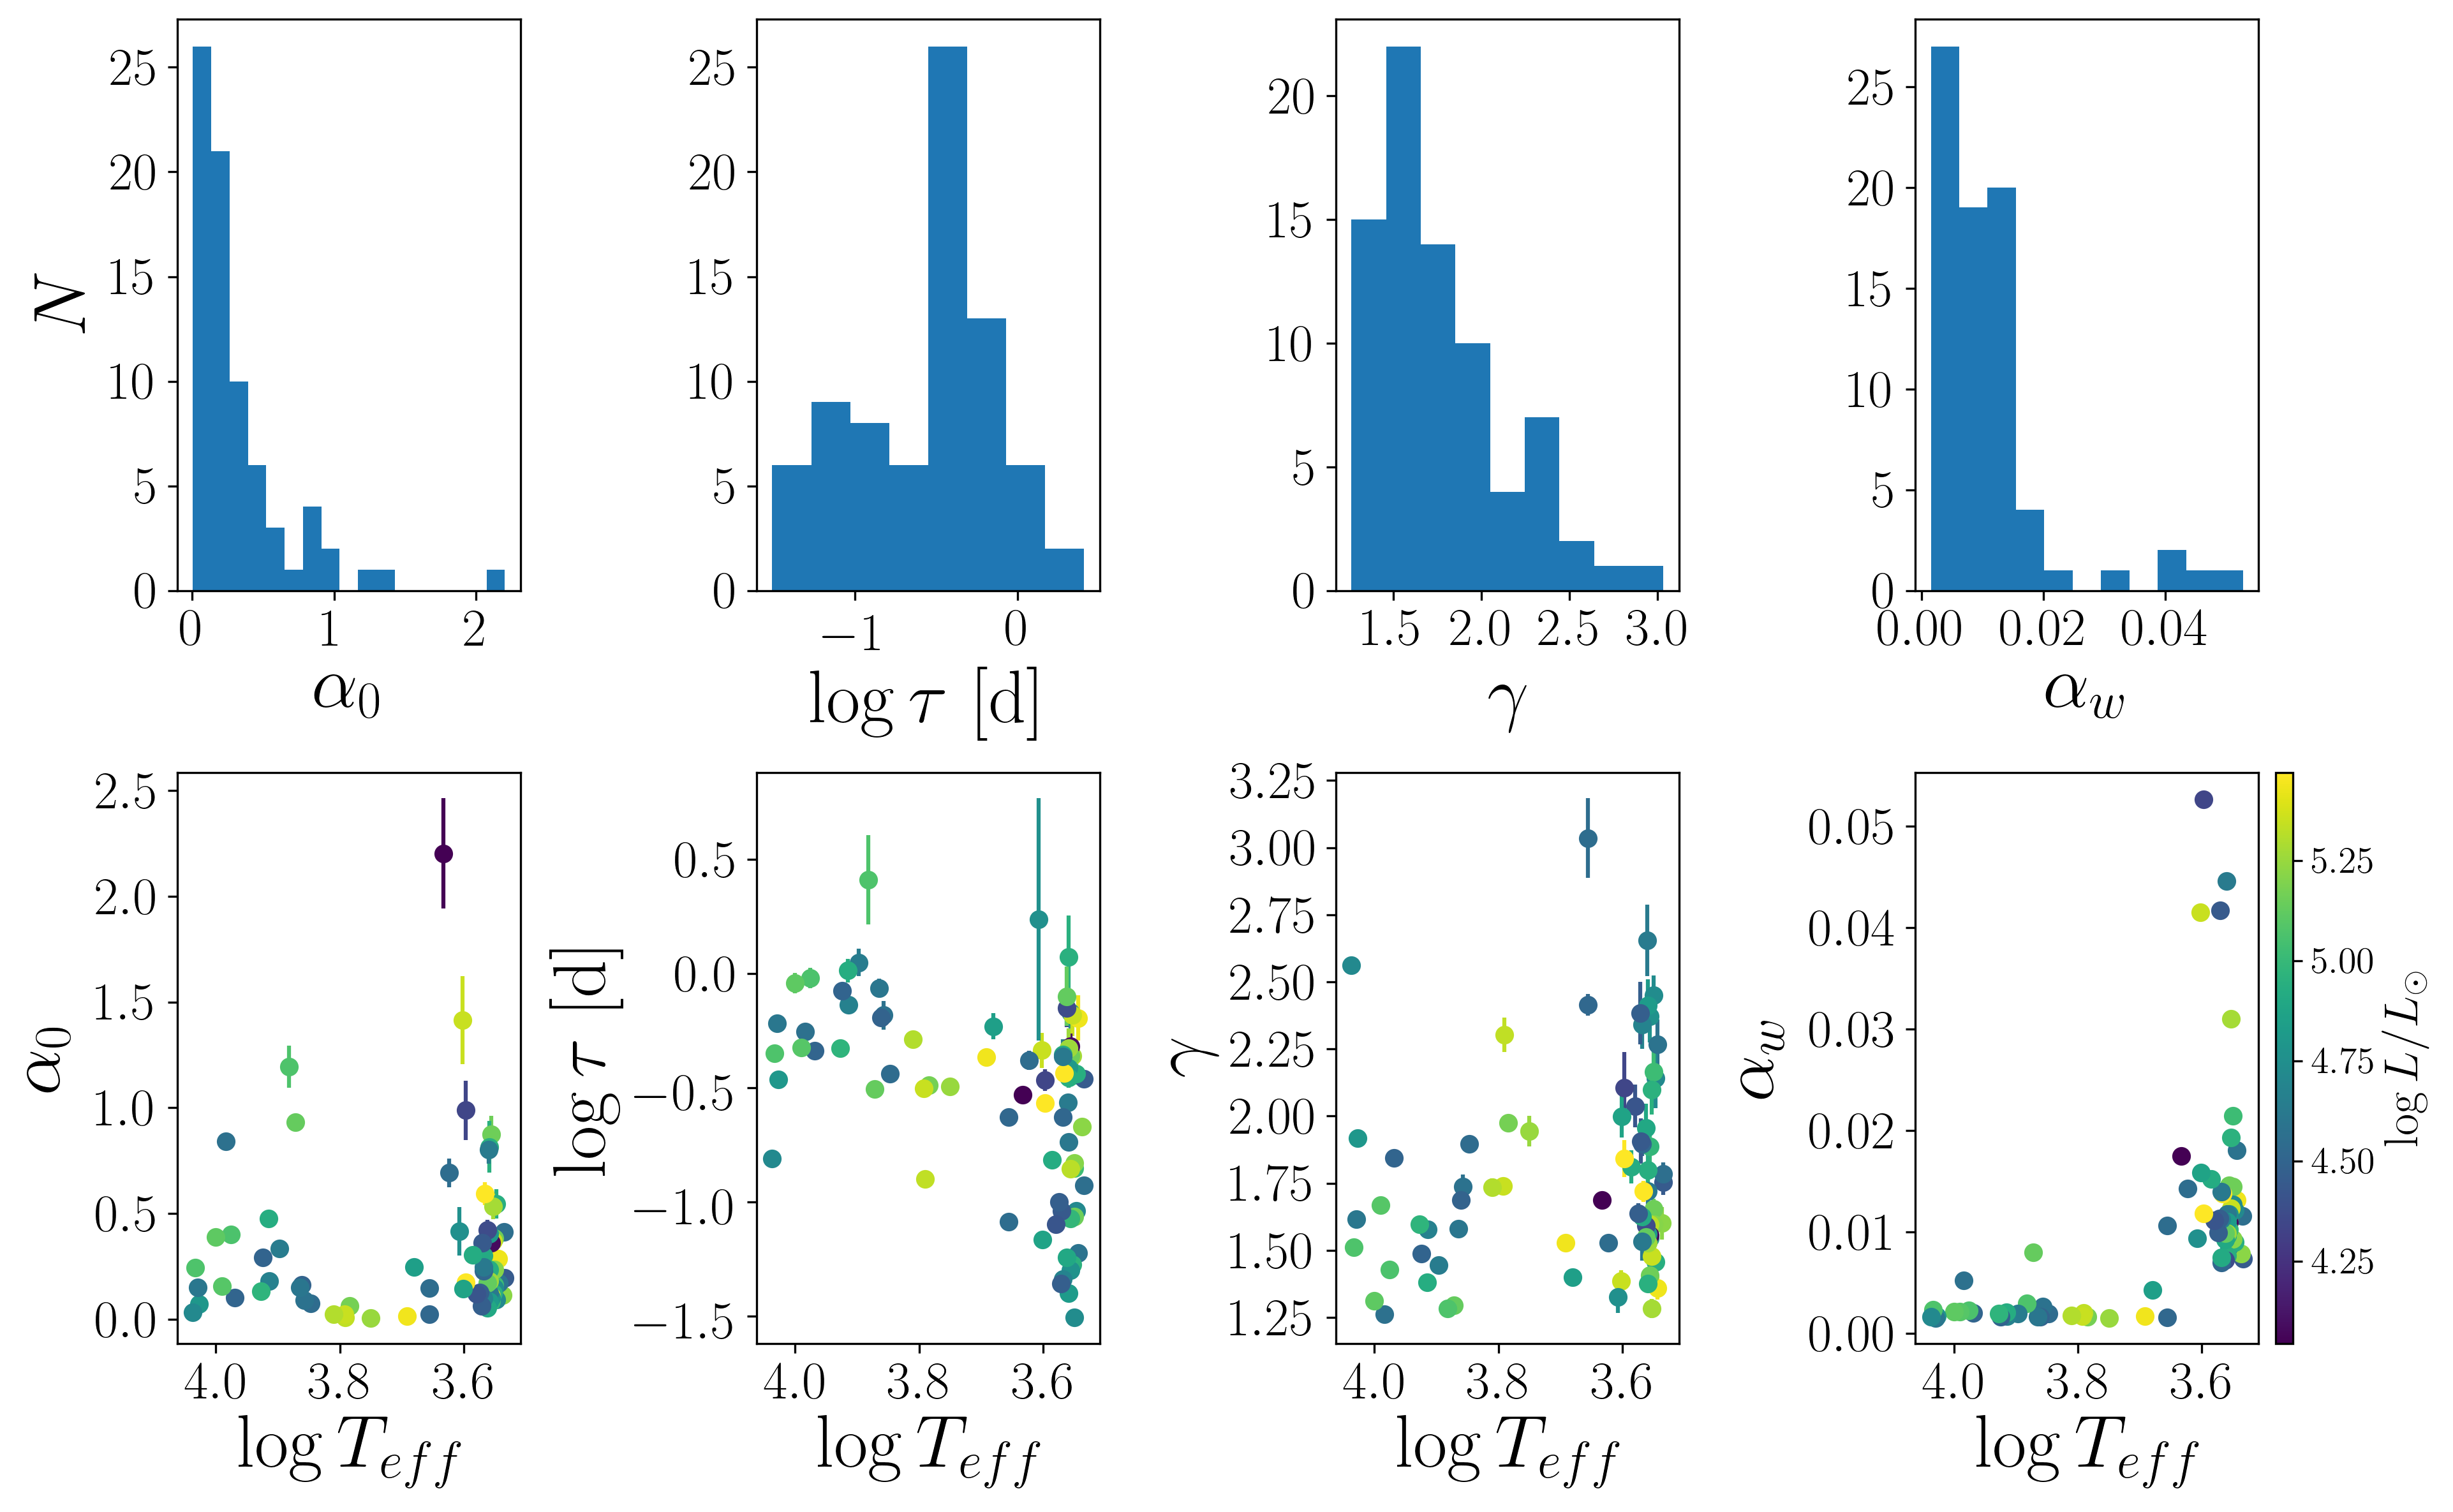

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#distributions of fit parameters. Only cool thing: RSGs have slope ~2, consistent with... Love? Someone?
fig, axes = plt.subplots(2, 4, figsize=(12,8), dpi=300)
cmap = cm.get_cmap('viridis')
norm = colors.Normalize(vmin=cool_sgs['lum'].min(),vmax=cool_sgs['lum'].max())

axes[0,0].hist(alphas, bins='auto')
axes[0,1].hist(np.log10(taus), bins='auto')
axes[0,2].hist(gammas[gammas > 0], bins='auto')
axes[0,3].hist(alpha_w, bins='auto')
for j,star in cool_sgs.iterrows():
    if star['gamma'] > 0:
        axes[1,0].errorbar(star['teff'],star['alpha'],yerr=star['e_alpha'],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,1].errorbar(star['teff'],np.log10(star['tau']),yerr=star['e_tau'],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,2].errorbar(star['teff'],star['gamma'],yerr=star['e_gamma'],fmt='o',c=cmap(norm(star['lum'])))
        axes[1,3].errorbar(star['teff'],star['alpha_w'],yerr=star['e_alpha_w'],fmt='o',c=cmap(norm(star['lum'])))
    
axes[0,0].set(xlabel=r'$\alpha_0$',ylabel='$N$')
axes[0,1].set(xlabel=r'$\log\tau$ [d]')
axes[0,2].set(xlabel=r'$\gamma$')
axes[0,3].set(xlabel=r'$\alpha_w$')

axes[1,0].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\alpha_0$')
axes[1,1].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\log\tau$ [d]')
axes[1,2].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\gamma$')
axes[1,3].set(xlabel=r'$\log{T_{eff}}$',ylabel=r'$\alpha_w$')

axins = inset_axes(axes[1,3],
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 100%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=axes[1,3].transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),cax=axins,orientation='vertical',pad=0.2)
cbar.set_label('$\log L/L_{\odot}$',fontsize=18)
cbar.ax.tick_params(labelsize=14)

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
        
for ax in axes[1,:]:
    ax.invert_xaxis()

plt.tight_layout()

plt.savefig('../plots/fit_params.pdf',bbox_inches='tight')

In [25]:
pd.read_table('../data/Geneva/M009Z02V0.dat',skiprows=2,names=['line','time','mass','lg(L)','lg(Teff)','1H_surf','4He_surf','12C_surf','13C_surf','14N_surf','16O_surf','17O_surf','18O_surf','20Ne_surf','22Ne_surf','26Al_surf','Mcc/Mt','lg(Teff)_x','lg(Md)','lg(rhoc)','lg(Tc)','1H_cen','4He_cen','12C_cen','13C_cen','14N_cen','16O_cen','17O_cen','18O_cen','20Ne_cen','22Ne_cen','26Al_cen','Omeg_surf','Omeg_cen','Rp/Req ','Md/Md(0)','v_crit1','v_crit2','v_equa','Om/Om_cr','Gamma_Ed','lg(Mdot_mech)','L_tot'],
            index_col='line',delim_whitespace=True)#sep=r"\s*")

time      mass     lg(L)  lg(Teff)   1H_surf  4He_surf  \
line                                                                   
1     2.560058e+05  8.999978  3.631524  4.444603  0.747086  0.250873   
2     8.758387e+05  8.999932  3.636223  4.440842  0.747086  0.250873   
3     1.466156e+06  8.999887  3.641173  4.439948  0.747086  0.250873   
4     2.056473e+06  8.999840  3.646227  4.439520  0.747086  0.250873   
5     2.632032e+06  8.999793  3.651111  4.439193  0.747086  0.250873   
...            ...       ...       ...       ...       ...       ...   
396   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
397   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
398   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
399   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   
400   2.899688e+07  8.845414  4.440688  3.607534  0.734156  0.263797   

      12C_surf  13C_surf  14N_surf  16O_surf  ...  Omeg_cen  Rp/Req   \
line                                          ...                      
1     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
2     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
3     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
4     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
5     0.000326  0.000004  0.000094  0.000817  ...       0.0      1.0   
...        ...       ...       ...       ...  ...       ...      ...   
396   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
397   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
398   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
399   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   
400   0.000165  0.000009  0.000353  0.000727  ...       0.0      1.0   

      Md/Md(0)  v_crit1  v_crit2  v_equa  Om/Om_cr  Gamma_Ed  lg(Mdot_mech)  \
line                                                                          
1          1.0      0.0      0.0     0.0       0.0  0.012774            0.0   
2          1.0      0.0      0.0     0.0       0.0  0.012913            0.0   
3          1.0      0.0      0.0     0.0       0.0  0.013061            0.0   
4          1.0      0.0      0.0     0.0       0.0  0.013214            0.0   
5          1.0      0.0      0.0     0.0       0.0  0.013364            0.0   
...        ...      ...      ...     ...       ...       ...            ...   
396        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
397        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
398        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
399        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   
400        1.0      0.0      0.0     0.0       0.0  0.083135            0.0   

      L_tot  
line         
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0  
...     ...  
396     0.0  
397     0.0  
398     0.0  
399     0.0  
400     0.0  

[400 rows x 42 columns]

/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


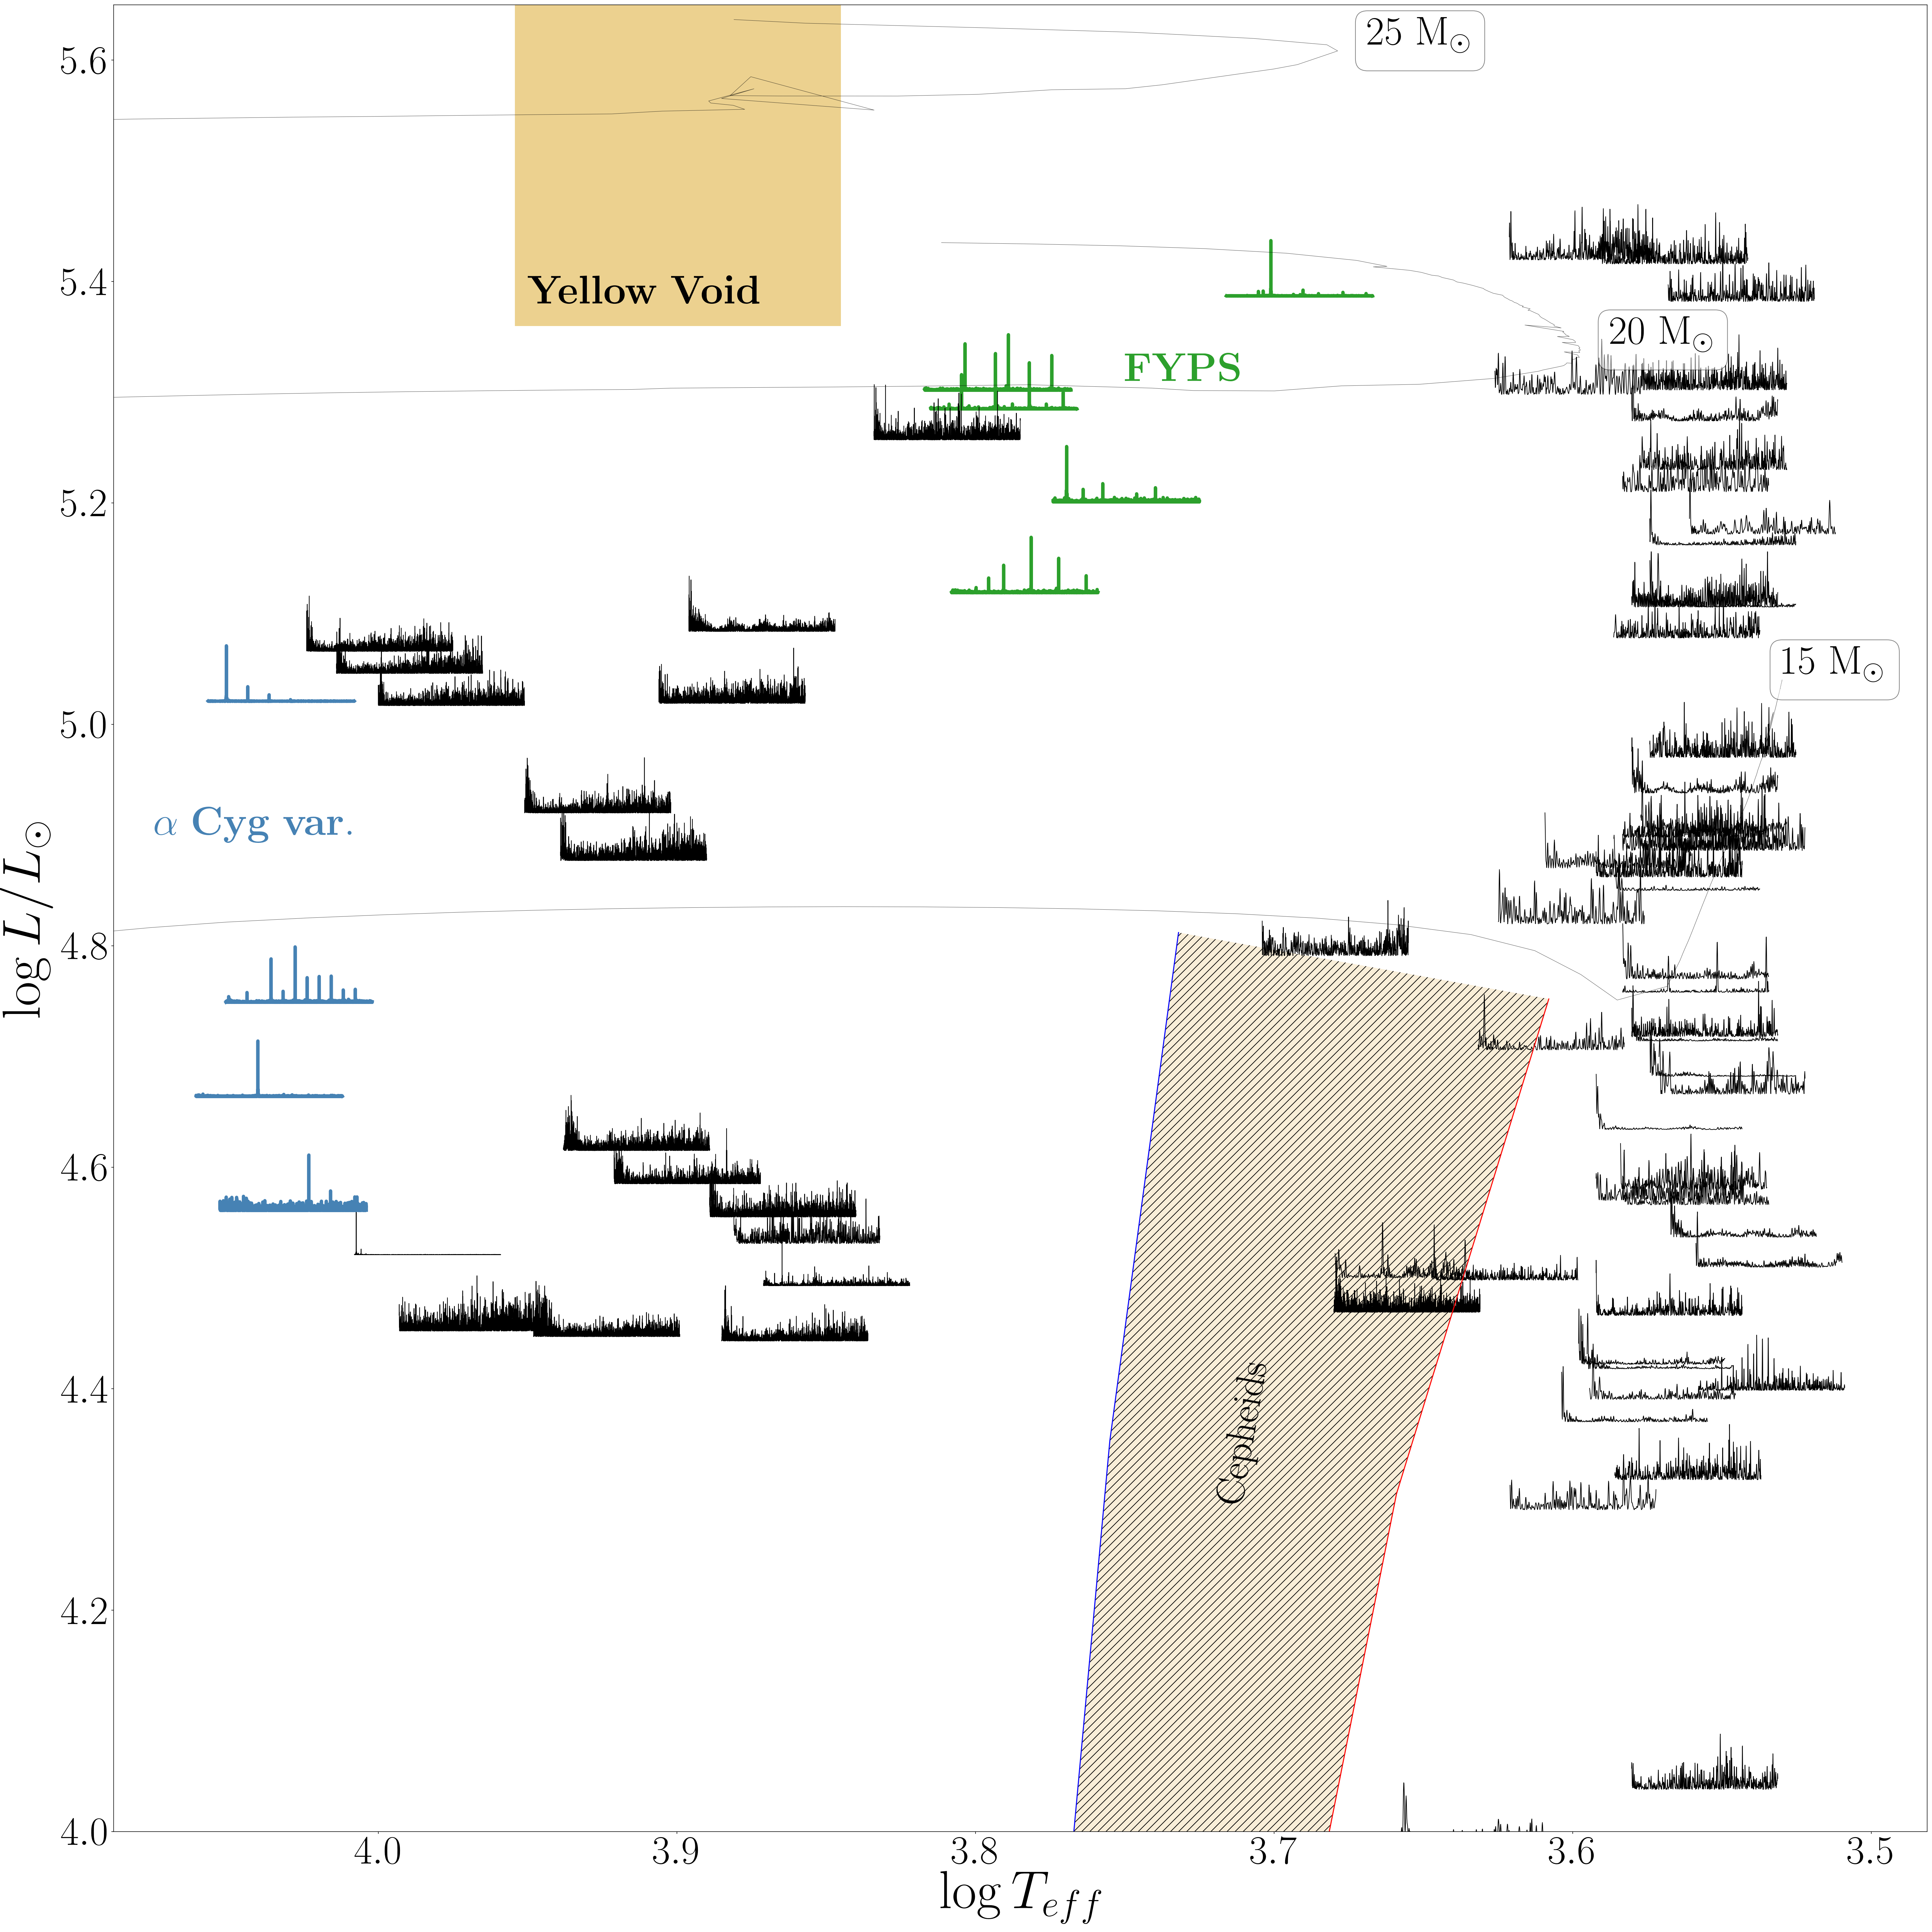

In [27]:
fig = plt.figure(figsize=(40,40),dpi=150)
fyps = cool_sgs[(cool_sgs['teff'] >= 3.69)&(cool_sgs['teff'] <= 3.8)&(cool_sgs['lum']>= 5.1)&(cool_sgs['lum']<=5.5)]
aceps = cool_sgs[(cool_sgs['teff'] >= 4.0)&(cool_sgs['lum'] <= 5.1)]

from matplotlib import lines as mlines

#Plot RPS
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for j,star in tqdm(cool_sgs.iterrows(), total=len(cool_sgs)):
        if star['TIC ID'] in fyps['TIC ID'].values:
            c = 'C2'
            lw=5
        elif star['TIC ID'] in aceps['TIC ID'].values:
            c='steelblue'
            lw=5
        else:
            c='k'
            lw=1
        x = star['teff']
        y = star['lum']
        plt.plot(0.01*(-freqs[j] + 2.5) + x,0.05*(resids[j]/resids[j].max()) - 0.05 + y,c=c,lw=lw,rasterized=True)

#Invert Axes and get xlimits
ax = plt.gca()
ax.invert_xaxis()
xl = ax.get_xlim()

for m in [15,20,25]: 
    try:
        model = pd.read_csv(f'mesa/propagation_diagram/out_post/mesa_initial_mass_{m}__/mesa_profile_attributes.csv')
        model.sort_values(by='model_number',inplace=True)
        min_num = model['model_number'].loc[np.argmin(model['Teff'])]
        pre = model[model['model_number'] < min_num]
        post = model[(model['model_number'] >= min_num)]
        if post['Teff'].max() >= 7000:
            yv_num = post['model_number'][np.argmin(np.abs(post['Teff'] - 7000))]
        else:
            yv_num = model['model_number'].max()+1
        post = post[post['model_number'] < yv_num]
        ax.plot(np.log10(model['Teff'][model['model_number'] < yv_num]),np.log10(model['photosphere_L'][model['model_number'] < yv_num]),lw=0.5,alpha=0.7,c='k')
    except:
        pass
    if m % 5 == 0:
        if m == 15:
            offset = 0.01#.1
        else:
            offset = 0
        plt.text(np.log10(model['Teff']).min()-0.01+offset,np.log10(model['photosphere_L'])[np.argmin(model['Teff'])],
                     str(m)+r' M$_\odot$',bbox=dict(facecolor='white',boxstyle='round',alpha=0.5),fontdict={'fontsize':60})


#Plot Cepheid strip
ln1 = plt.plot(instability_strip['logTeff1'],instability_strip['logL1'],c='b')
ln2 = plt.plot(instability_strip['logTeff2'],instability_strip['logL2'],c='r')
inst_t = np.array([s['logTeff1'] for _,s in instability_strip.iterrows()])
inst_l = np.array([s['logL1'] for _,s in instability_strip.iterrows()])
for i,s in instability_strip.iterrows():
    if i == 0:
        inst_t = np.append(inst_t,s['logTeff2'])
        inst_l = np.append(inst_l,s['logL2'])
    else:
        inst_t = np.insert(inst_t,-1*i,s['logTeff2'])
        inst_l = np.insert(inst_l,-1*i,s['logL2'])
coords = np.hstack((inst_t[:,np.newaxis],inst_l[:,np.newaxis]))
poly = plt.Polygon(coords,fc='wheat',alpha=0.5,hatch='//')
ax.add_patch(poly)
plt.text(3.72,4.3,'Cepheids',fontdict={'fontsize':60},rotation=80)

#Plot Yellow Void, label alpha Cygnis
ylim = [4.0,5.65]
ymin = (5.36 - ylim[0])/(ylim[1]-ylim[0])

yv = plt.axvspan(xmin=np.log10(7000),xmax=np.log10(9000),ymin=ymin,fc='goldenrod',alpha=0.5)
#ac = plt.axvspan(xmin=4,xmax=4.1,ymin=0.325,ymax=0.675,fc='steelblue',alpha=0.5)
plt.text(3.95,5.38,r'$\mathrm{\bf Yellow\ Void}$',fontdict={'fontsize':60})
plt.text(4.075,4.9,r'${\bf \alpha\ } \mathrm{\bf Cyg\ var.}$',fontdict={'fontsize':60,'color':'steelblue'})
plt.text(3.75,5.31,r'$\mathrm{\bf FYPS}$',fontdict={'fontsize':60,'color':'C2'})


ax.set(xlabel=r'$\log T_{eff}$', ylabel=r'$\log L/L_{\odot}$',ylim=ylim,xlim=xl)
ax.xaxis.label.set_size(80)
ax.yaxis.label.set_size(80)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(60)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(60)
    
"""plt.legend(handles=[mlines.Line2D([], [], color='k',ls=l,label=p) for l,p in zip(['-','--'],[r'$Z=0.014$',r'$Z=0.002$'])],loc=3, prop={'size': 60})
"""    
plt.tight_layout()
plt.savefig('../plots/dered_hr.pdf')

In [20]:
# FYPS are
# 1. Variable by van Genderen 06. Paper I
# 2. Nothing, Paper I
# 3. Nothing, Paper I
# 4. Misc. variable in Ulaczyk (2013)
# 5. Nothing

fyps.to_csv('fyps.csv',index=False)
fyps[['CommonName','TIC ID','RA','Dec','teff','lum']]

CommonName     TIC ID         RA        Dec   teff    lum
50  HD 269953  404850274  85.050696 -69.668015  3.692  5.437
51  HD 269110   40404470  77.294202 -69.603390  3.750  5.251
52  HD 268687   29984014  72.732736 -69.431251  3.784  5.169
53  HD 269840  277108449  84.042007 -68.928129  3.791  5.335
54  HD 269902  277300045  84.539929 -69.105921  3.793  5.352

In [21]:
#alpha cygnis are identified as:
# 1. Put forth as a candidate Alpha Cyg variable by Balona (2019)
# 2. Nothing
# 3. Ellipsoidal/rotational modulation by Pedersen, eclipsing binary by Balona
# 4. Nothing
aceps[['CommonName','lum']]

CommonName    lum
72    HD 269101  4.799
73  SK -69   68  4.611
74    HD 268798  5.071
75    HD 269769  4.714

# Let's see if we take all possible sets of 5 stars from this sample, how many of them have an equal or smaller spread in $\log T_{eff}$ and $\log L$.

In [22]:
import math

def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

print(nCr(len(cool_sgs),5))

18474840.0


In [23]:
def dTL_range(indices):
    this_set = cool_sgs.iloc[list(indices)]
    return this_set['teff'].max() - this_set['teff'].min(),this_set['lum'].max() - this_set['lum'].min()

In [24]:
from itertools import combinations
from multiprocessing import Pool, cpu_count

fyps = cool_sgs[(cool_sgs['teff'] <= 3.8) & (cool_sgs['teff'] >= 3.69) & (cool_sgs['lum'] >= 5.1) & (cool_sgs['lum'] <= 5.5)]
print(len(fyps))

dT_fyps = fyps['teff'].max() - fyps['teff'].min()
dL_fyps = fyps['lum'].max() - fyps['lum'].min()

with Pool(cpu_count() - 1) as p:
    dTLs = list(
        tqdm(
            p.imap(dTL_range, combinations(np.arange(len(cool_sgs),dtype=int),5)), total=nCr(len(cool_sgs),5)
             )    
                )
    
dTLs = np.array(dTLs)

5


0.08784325060460604 0.011888276163690727 0.0007451756009794943


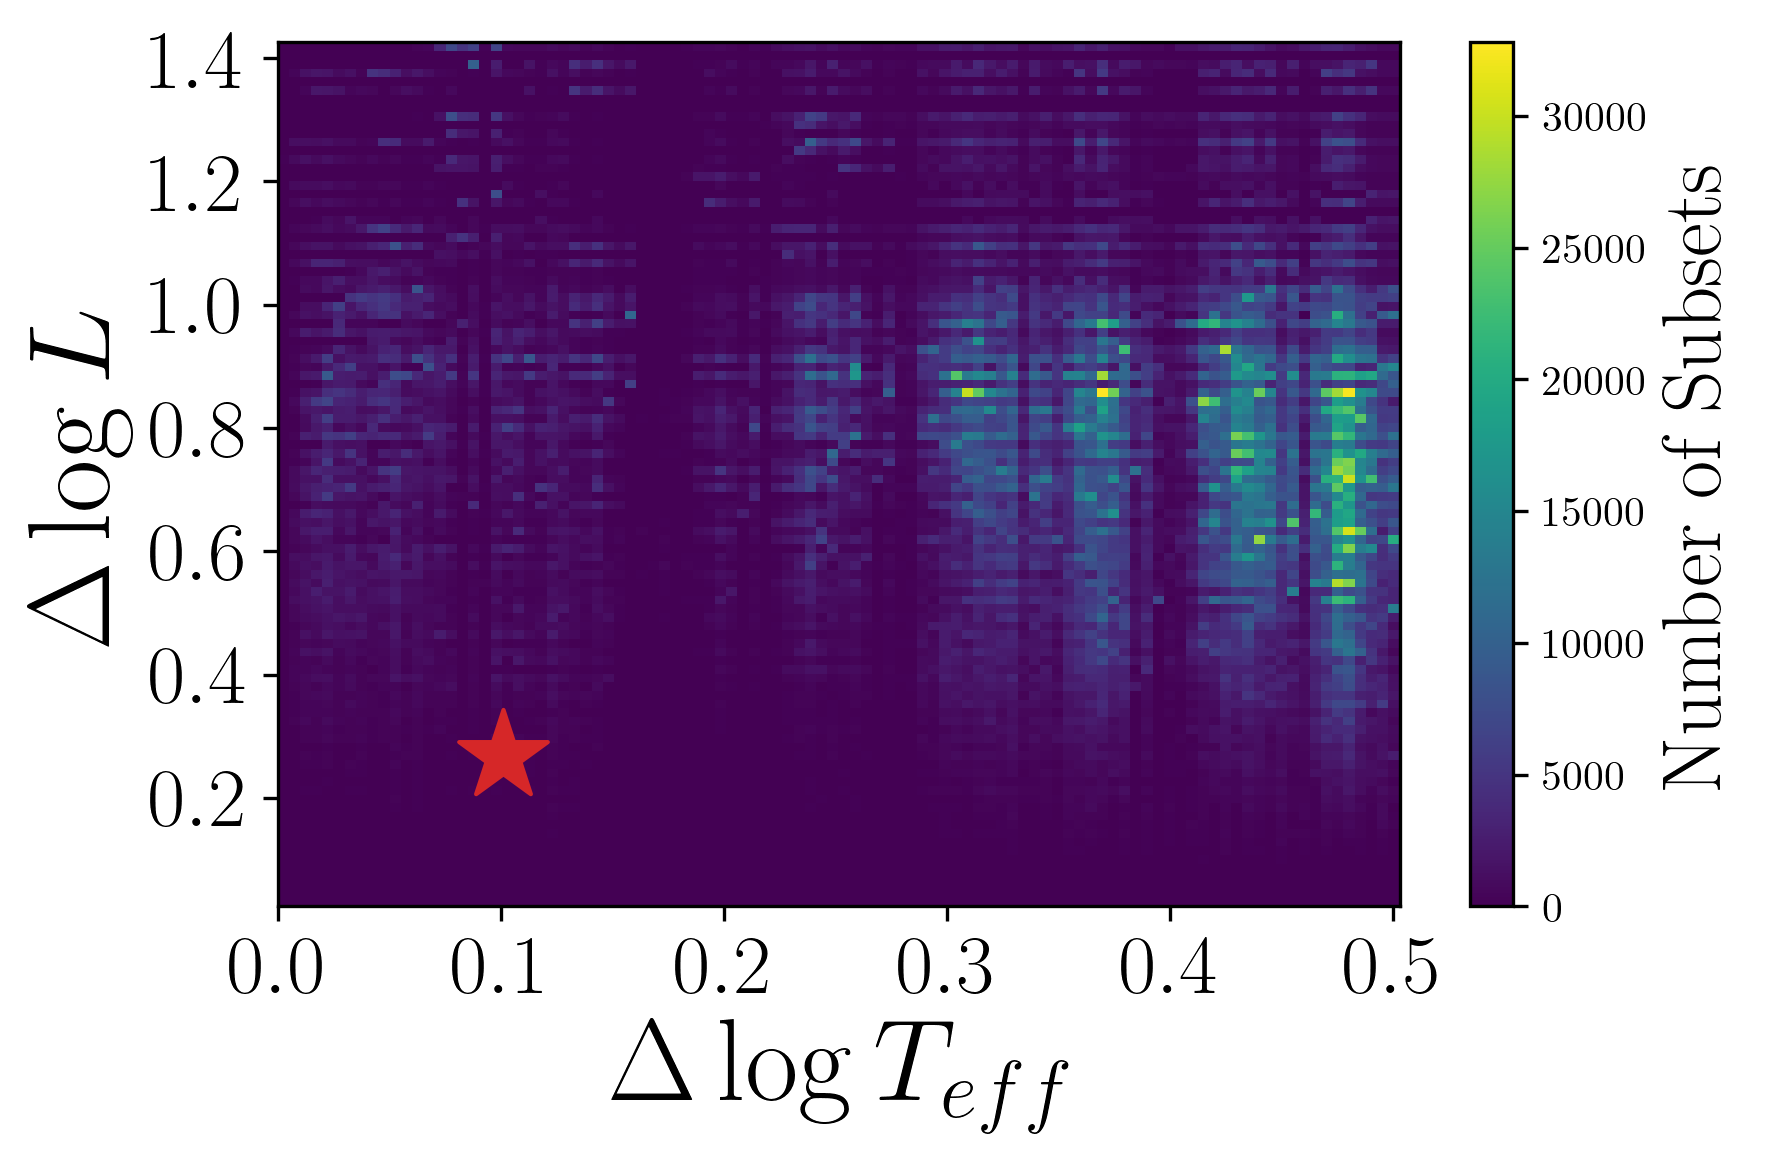

In [25]:
fig = plt.figure(dpi=300)
plt.hist2d(dTLs[:,0],dTLs[:,1],bins=100)
cb = plt.colorbar()
cb.set_label(label='Number of Subsets',fontsize='20')
print(len(dTLs[(dTLs[:,0] <= dT_fyps)])/len(dTLs),len(dTLs[(dTLs[:,1] <= dL_fyps)])/len(dTLs),len(dTLs[(dTLs[:,1] <= dL_fyps)&(dTLs[:,0] <= dT_fyps)])/len(dTLs))
plt.scatter(dT_fyps,dL_fyps,c='C3',marker='*',s=500)
plt.xlabel(r'$\Delta\log{T_{eff}}$')
plt.ylabel(r'$\Delta\log{L}$')
ax = plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()
plt.savefig('../plots/clustering_simulation.pdf')

In [175]:
ysgs_range = cool_sgs[cool_sgs['SpT']=='YSG'].reset_index(drop=True)
def dTL_range_ysg(indices):
    this_set = ysgs_range.iloc[list(indices)]
    return this_set['teff'].max() - this_set['teff'].min(),this_set['lum'].max() - this_set['lum'].min()

with Pool(cpu_count() - 1) as p:
    dTLs_ysg = list(
        tqdm(
            p.imap(dTL_range_ysg, combinations(np.arange(len(ysgs_range),dtype=int),5)), total=nCr(len(ysgs_range),5)
             )    
                )
    
dTLs_ysg = np.array(dTLs_ysg)

print(len(dTLs_ysg[(dTLs_ysg[:,0] <= dT_fyps)])/len(dTLs_ysg),len(dTLs_ysg[(dTLs_ysg[:,1] <= dL_fyps)])/len(dTLs_ysg),len(dTLs_ysg[(dTLs_ysg[:,1] <= dL_fyps)&(dTLs_ysg[:,0] <= dT_fyps)])/len(dTLs_ysg))


0.011334961334961336 0.01334961334961335 0.0002747252747252747


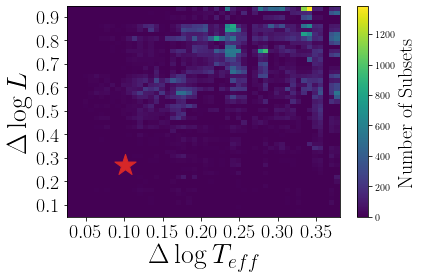

In [179]:
plt.hist2d(dTLs_ysg[:,0],dTLs_ysg[:,1],bins=50)
cb = plt.colorbar()
cb.set_label(label='Number of Subsets',fontsize='20')
plt.scatter(dT_fyps,dL_fyps,c='C3',marker='*',s=500)
plt.xlabel(r'$\Delta\log{T_{eff}}$')
plt.ylabel(r'$\Delta\log{L}$')
ax = plt.gca()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.tight_layout()